In [1]:
import os
import json
import glob
import copy
import copy
import itertools
import pprint 
pp = pprint.PrettyPrinter(indent=4)

import numpy as np
import pylab as pl
import seaborn as sns
import pandas as pd
import statsmodels as sm
import cPickle as pkl

from scipy import stats as spstats

from pipeline.python.classifications import experiment_classes as util
from pipeline.python.classifications import aggregate_data_stats as aggr
from pipeline.python.classifications import rf_utils as rfutils
from pipeline.python import utils as putils

from pipeline.python.classifications import decode_by_ncells as dc
from pipeline.python.classifications import decode_utils as decutils
from pipeline.python.retinotopy import fit_2d_rfs as fitrf

from matplotlib.lines import Line2D
import matplotlib.patches as patches

In [2]:
%matplotlib notebook

In [3]:
# Set colors
visual_areas, area_colors = putils.set_threecolor_palette()
dpi = putils.set_plot_params()


# Dataset info

In [4]:
#### Set options
analysis_type='split_pupil'
n_iterations=100
overlap_thr=None
n_processes=1
responsive_test='nstds'
experiment='blobs'
C_value=None

options=['-E', experiment, '-R', responsive_test, '-n', n_processes, '-N', n_iterations, 
         '-o', overlap_thr, '-C', C_value, '-X', analysis_type]


In [7]:
#### Extract options
opts = dc.extract_options(options)
fov_type = 'zoom2p0x'
state = 'awake'
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'
rootdir = opts.rootdir
create_new = opts.create_new
verbose=opts.verbose

# Pick dataset ------------------------------------ 
traceid = opts.traceid #'traces001'

response_type = opts.response_type #'dff'
responsive_test = opts.responsive_test #'nstds' # 'nstds' #'ROC' #None
if responsive_test=='None':
    responsive_test=None
responsive_thr = float(opts.responsive_thr) if responsive_test is not None else 0.05 #10

# Classifier info ---------------------------------
experiment = opts.experiment #'blobs'
class_a=int(opts.class_a) #0
class_b=int(opts.class_b) #106
n_iterations=int(opts.n_iterations) #100 
n_processes=int(opts.n_processes) #2
trial_epoch = 'stimulus'

analysis_type=opts.analysis_type

# CV ----------------------------------------------
test_split=0.2
cv_nfolds=5
C_value=opts.C_value
# do_cv = opts.do_cv
#C_value = opts.C_value
do_cv = C_value is None

print("Do CV -%s- (C=%s)" % (str(do_cv), str(C_value)))

# Dataset filtering --------------------------------
filter_fovs = True
remove_too_few = True
min_ncells = 10 if remove_too_few else 0
overlap_thr = None if opts.overlap_thr in ['None', None] else float(opts.overlap_thr)
has_rfs = overlap_thr is not None

stim_filterby = None # 'first'
has_gratings = experiment!='blobs'

match_distns = opts.match_distns
if analysis_type=='single_cells':
    match_distns = False
match_str = 'matchdistns_' if match_distns else ''

# Pupil -------------------------------------------
pupil_feature='pupil_area'
pupil_alignment='trial'
pupil_epoch='pre'
pupil_snapshot=391800
redo_pupil=False
pupil_framerate=20.
# -------------------------------------------------

# Alignment 
iti_pre=1.
iti_post=1.
stim_dur=1.

# RF stuff 
rf_filter_by=None
reliable_only = True
rf_fit_thr = 0.05

Do CV -True- (C=None)


In [8]:
train_str = '%s_iter-%i' % (analysis_type, n_iterations)

# Set colors
visual_area, area_colors = putils.set_threecolor_palette()
dpi = putils.set_plot_params()

# Output dir

In [9]:
#### Output dir
stats_dir = os.path.join(aggregate_dir, 'data-stats')

dst_dir = os.path.join(aggregate_dir, 'decoding', analysis_type)
if not os.path.exists(dst_dir):
    os.makedirs(dst_dir)
    print(dst_dir)
print(dst_dir)

/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/split_pupil


# Get metadata for experiment type

In [11]:
#### Get metadata for experiment type
sdata = aggr.get_aggregate_info(traceid=traceid, fov_type=fov_type, state=state)
edata, expmeta = aggr.experiment_datakeys(sdata, experiment=experiment,
                                      has_gratings=has_gratings, stim_filterby=stim_filterby)
    
# Get blob metadata only - and only if have RFs
if has_rfs:
    dsets = pd.concat([g for k, g in edata.groupby(['animalid', 'session', 'fov']) if 
                        (experiment in g['experiment'].values 
                         and ('rfs' in g['experiment'].values \
                              or 'rfs10' in g['experiment'].values)) ])
else:
    dsets = edata.copy()
    
dsets[['visual_area', 'datakey']].drop_duplicates().groupby(['visual_area']).count()


Segmentation: missing 9 dsets
Segmentation: missing 9 dsets


,datakey
visual_area,
Li,18
Ll,3
Lm,16
V1,16


In [12]:
#### Check stimulus configs
stim_datakeys = dsets['datakey'].unique()
# SDF = aggr.check_sdfs(stim_datakeys, traceid=traceid)

#### Load neural responses
trial_epoch='stimulus'
responsive_test='nstds' #'roc'
responsive_thr=10 #10 #0.05
response_type='dff'

#### Create ID str


#### Check for equal trial counts
_, cells, MEANS, SDF = aggr.get_source_data(experiment, equalize_now=True, response_type=response_type,
                                      responsive_test=responsive_test, responsive_thr=responsive_thr, 
                                      trial_epoch=trial_epoch, return_configs=True) 
cells = cells[cells['visual_area'].isin(visual_areas)]
cells.groupby(['visual_area']).count()


Segmentation: missing 9 dsets
...loading: /n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/aggr_blobs_trialmeans_traces001_nstds-thr-10.00_dff_stimulus.pkl
*Warning* <20190314_JC070_fov1> More than 1 pos? x: [-15   0], y: [-5  0]
---equalizing now---
Segmentation: missing 9 dsets
Segmentation: missing 3 dsets


,cell,fov,animalid,session,datakey,fovnum
visual_area,,,,,,
Li,1142,1142,1142,1142,1142,1142
Lm,1970,1970,1970,1970,1970,1970
V1,2089,2089,2089,2089,2089,2089


In [22]:
stack_neuraldf=True

#### Load RF fits -------------------------------------
rf_filter_by=None
reliable_only = True
rf_fit_thr = 0.05
if has_rfs: 
    print("~~~~~~~~~~~~~~~~Loading RFs~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
    rf_fit_desc = fitrf.get_fit_desc(response_type=response_type)
    reliable_str = 'reliable' if reliable_only else ''
    rf_str = 'match%s_%s' % (experiment, reliable_str)
    # Get position info for RFs 
    rfdf = aggr.load_rfdf_and_pos(dsets, rf_filter_by=None, 
                                    reliable_only=True, traceid=traceid)
    # RF dataframes
    NEURALDATA, RFDATA = aggr.get_neuraldata_and_rfdata(cells, rfdf, MEANS, stack=stack_neuraldf)
else:
    rf_str = 'noRFs'
    print("~~~~~~~~~~~~~~~~No Receptive Fields~~~~~~~~~~~~~~~~~~~~~~~~~")
    # EXP dataframes 
    NEURALDATA = aggr.get_neuraldata(cells, MEANS, stack=stack_neuraldf)

if match_distns:
    print("~~~~~~~~~~~~~~~~Matching max %s distNs~~~~~~~~~~~~~~~~~~~~~" % response_type)
    NEURALDATA, selected_cells = aggr.match_neuraldata_distn(NEURALDATA, src='Li')
    if has_rfs:
        RFDATA = select_dataframe_subset(selected_cells, RFDATA)

dist_str = 'matchdist_' if match_distns else ''

~~~~~~~~~~~~~~~~Loading RFs~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
N dpaths: 42, N unfit: 0
N datasets included: 42, N sessions excluded: 4


In [24]:
counts = NEURALDATA[['visual_area', 'datakey', 'cell']].drop_duplicates().groupby(['visual_area', 'datakey']).count().reset_index()
counts

,visual_area,datakey,cell
0,Li,20190602_JC091_fov1,58
1,Li,20190606_JC091_fov1,16
2,Li,20190607_JC091_fov1,31
3,Li,20190609_JC099_fov1,21
4,Li,20190612_JC099_fov1,13
5,Li,20190614_JC091_fov1,40
6,Li,20190617_JC099_fov1,2
7,Li,20191018_JC113_fov1,6
8,Li,20191105_JC117_fov1,1
9,Li,20191111_JC120_fov1,1


In [26]:
has_rfs

True

#### Combine into stacked df

<IPython.core.display.Javascript object>


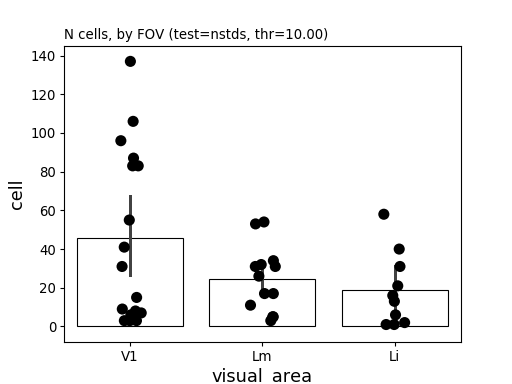

,visual_area,datakey,cell
0,Li,20190602_JC091_fov1,58
1,Li,20190606_JC091_fov1,16
2,Li,20190607_JC091_fov1,31
3,Li,20190609_JC099_fov1,21
4,Li,20190612_JC099_fov1,13
5,Li,20190614_JC091_fov1,40
6,Li,20190617_JC099_fov1,2
7,Li,20191018_JC113_fov1,6
8,Li,20191105_JC117_fov1,1
9,Li,20191111_JC120_fov1,1


In [25]:
fig, ax = pl.subplots()
# sns.barplot(x='visual_area', y='cell', data=counts, ax=ax,
#            hue='datakey', palette='colorblind')
# ax.legend_.remove()
sns.barplot(x='visual_area', y='cell', data=counts, ax=ax,
           facecolor='w', edgecolor=('k', 'k', 'k'), order=visual_areas)
sns.stripplot(x='visual_area', y='cell', data=counts, ax=ax,
            order=visual_areas, color='k', s=10)
ax.set_title("N cells, by FOV (test=%s, thr=%.2f)" % (responsive_test, responsive_thr), loc='left')
counts

# Pupil

In [13]:
from pipeline.python.eyetracker import dlc_utils as dlcutils

In [15]:
pupil_feature = 'pupil_area'
pupil_epoch = 'pre'
alignment_type='trial'
pupil_snapshot=391800

redo_pupil=True 
pupil_framerate=20.   
iti_pre=1.
iti_post=1.
stim_dur=1.
n_cuts=3

#if 'pupil' in analysis_type:
pupildata = dlcutils.get_aggregate_pupildfs(experiment=experiment, 
                                        feature_name=pupil_feature, 
                                        alignment_type=alignment_type,
                                        trial_epoch=pupil_epoch,
                                        iti_pre=iti_pre, iti_post=iti_post, stim_dur=stim_dur,
                                        in_rate=pupil_framerate, out_rate=pupil_framerate,
                                        snapshot=pupil_snapshot, create_new=redo_pupil)

~~~~~ Aggregating pupil traces. ~~~~~~
Segmentation: missing 9 dsets
Aggregated pupil traces. Missing 10 datasets.
20190306_JC061_fov3
20190319_JC067_fov1
20190320_JC067_fov1
20190314_JC070_fov1
20190315_JC070_fov1
20190316_JC070_fov1
20190321_JC070_fov1
20190322_JC073_fov1
20190327_JC073_fov1
20190422_JC076_fov1
~~~~~~~~~~~~ Aggregating pupil dataframes. ~~~~~~~~~~~


KeyboardInterrupt: 

## Test classifier w/ example FOV

In [33]:
datakey = '20190612_JC099_fov1'
session, animalid, fovn = datakey.split('_')
fovnum = int(fovn[3:])
visual_area='Li'
datakey in pupildata.keys()


# ------ STIMULUS INFO -----------------------------------------
obj = util.Objects(animalid, session, 'FOV%i_zoom2p0x' %  fovnum, traceid=traceid)
sdf = obj.get_stimuli()


In [37]:
neuraldf = aggr.get_neuraldf_for_cells_in_area(cells, MEANS, datakey=datakey, visual_area=visual_area)
n_cells = int(neuraldf.shape[1]-1)
curr_rois = cells[(cells['datakey']==datakey) & (cells['visual_area']==visual_area)]['cell'].values
assert n_cells==len(curr_rois)

In [38]:
print("... [%s] %s, n=%i cells" % (visual_area, datakey, n_cells))

... [Li] 20190612_JC099_fov1, n=51 cells


In [39]:
pupildf = pupildata[datakey].copy()
pupildf.shape

(1500, 5)

In [40]:
# match neural trials, pupil trials
neuraldf, pupildf = dlcutils.match_trials_df(neuraldf, pupildf, equalize_conditions=True)

# zscore
neuraldf = aggr.zscore_neuraldf(neuraldf)

In [41]:
pupil_low, pupil_high = dlcutils.split_pupil_range(pupildf, feature_name=pupil_feature, n_cuts=n_cuts)
print(pupil_low.shape, pupil_high.shape)


((500, 5), (500, 5))


In [42]:
low_trial_ixs = pupil_low['trial'].unique()
high_trial_ixs = pupil_high['trial'].unique()
all_trial_ixs = pupildf['trial'].unique()


In [43]:
reload(aggr)

<module 'pipeline.python.classifications.aggregate_data_stats' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/aggregate_data_stats.py'>

In [44]:

# Decoding -----------------------------------------------------
arousal_conds = ['all', 'low', 'high']
arousal_trial_ixs = [all_trial_ixs, low_trial_ixs, high_trial_ixs]
iter_list=[]
for arousal_cond, curr_trial_ixs in zip(arousal_conds, arousal_trial_ixs):
    # Get neuraldf for current trials
    curr_data = neuraldf.loc[curr_trial_ixs].copy()
    # Fit.
    a_list = decutils.fit_svm_mp(curr_data, sdf, C_value=C_value, 
                            n_iterations=n_iterations, 
                            n_processes=n_processes, verbose=verbose,
                            class_a=class_a, class_b=class_b) 
    print("%i items in mp list" % len(a_list))
    # Aggregate 
    arousal_df = pd.concat(a_list, axis=0)
    metainfo = {'visual_area': visual_area, 'datakey': datakey,
                'arousal': arousal_cond, 'n_cells': n_cells}
    arousal_df = putils.add_meta_to_df(arousal_df, metainfo)
    iter_list.append(arousal_df)

print("%i items in split-pupil list" % len(iter_list))
# DATA - get mean across items
iter_results = pd.concat(iter_list, axis=0)

1 items in mp list
1 items in mp list
1 items in mp list
3 items in split-pupil list


In [46]:
iter_results.shape

(300, 14)

In [47]:
iter_results.groupby(['arousal']).mean()

,C,fit_time,heldout_MI,heldout_aMI,heldout_log2MI,heldout_test_score,n_cells,n_trials,score_time,test_score,train_score
arousal,,,,,,,,,,,
all,3.30472,0.106836,0.008496,0.001509,0.012258,0.514833,51,300,0.000667,0.548165,0.688407
high,0.48385,0.000945,0.017633,-0.000679,0.025440,0.472727,51,110,0.000308,0.533456,0.752631
low,0.18478,0.000661,0.009628,-0.006559,0.013891,0.505556,51,90,0.000287,0.543497,0.679035


# Test loading for example FOV

In [48]:
reload(dc)

<module 'pipeline.python.classifications.decode_by_ncells' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/decode_by_ncells.py'>

In [16]:
overlap_thr=None
C_value=None
trial_epoch='plushalf'

results_id = dc.create_results_id(prefix=analysis_type, C_value=C_value, 
                                response_type=response_type, responsive_test=responsive_test, 
                                overlap_thr=overlap_thr, trial_epoch=trial_epoch)
results_id

'split_pupil_varea__dff-nstds_no-rfs__plushalf__tuneC'

In [20]:
_, response_id, tepoch, C_str = results_id.split('__')
# C_str = 'tuneC' if C_value is None else 'C-%.2f' % float(C_value)
result_str = '%s__%s__%s__%s' % (analysis_type, response_id, tepoch, C_str)
result_str

'split_pupil__dff-nstds_no-rfs__plushalf__tuneC'

In [63]:
# datakey = '20190522_JC084_fov1'
# visual_area = 'V1'

datakey = '20190622_JC085_fov1'
visual_area = 'V1'

session, animalid, fovn = datakey.split('_')
fovnum = int(fovn[3:])
fov = 'FOV%i_zoom2p0x' % fovnum
results_id = dc.create_results_id(prefix=analysis_type, C_value=C_value, visual_area=visual_area,
                                response_type=response_type, responsive_test=responsive_test, 
                                overlap_thr=overlap_thr, trial_epoch=trial_epoch)

res = dc.load_decode_within_fov(animalid, session, fov, results_id=results_id, traceid=traceid)


In [65]:
traceid_dir = glob.glob(os.path.join(rootdir, animalid, session, fov, 'combined_blobs*',
                                     'traces', '%s*' % traceid))[0]
curr_dst_dir = os.path.join(traceid_dir, 'decoding')    
results_outfile = os.path.join(curr_dst_dir, '%s.pkl' % results_id)  


os.path.exists(results_outfile)


True

In [21]:
sorted(os.listdir(curr_dst_dir))


NameError: name 'curr_dst_dir' is not defined

In [22]:
#glob.glob(os.path.join(rootdir, 'JC*', '2019*', 'FOV*', 'combined_blobs_static', 'traces',
#                       '%s*' % traceid, 'decoding', 'inputdata_%s.pkl' % result_str))

d_=[]
for visual_area in visual_areas:
    curr_id = dc.create_results_id(prefix=analysis_type, C_value=C_value, 
                        visual_area=visual_area,
                        response_type=response_type, responsive_test=responsive_test, 
                        overlap_thr=overlap_thr, trial_epoch=trial_epoch)
    
    curr_inputfiles = glob.glob(os.path.join(rootdir, 'JC*', '2019*', 'FOV*', 'combined_blobs_static', 'traces',
                       '%s*' % traceid, 'decoding', 'inputdata_%s.pkl' % curr_id))
    print("%s: %i files" % (visual_area, len(curr_inputfiles)))

    for cf in curr_inputfiles:
        with open(cf, 'rb') as f:
            res = pkl.load(f)
            
        #res['neuraldf']['arousal']['high_ixs']
        xd = res['neuraldf'].copy()
        xd['arousal'] = 0
        xd['arousal'][res['high_ixs']] = 1
        xd['arousal'][res['low_ixs']] = -1

        tmpdf = pd.melt(xd, id_vars=['config', 'arousal'], 
                          var_name='cell',value_name='response')
        tmpdf['visual_area'] = visual_area
        tmpdf['datakey'] = datakey
        tmpdf['trial'] = tmpdf.index.tolist()
        d_.append(tmpdf)
        
neurald = pd.concat(d_,axis=0)


V1: 16 files


NameError: name 'datakey' is not defined

In [26]:
tmpdf.shape

(271500, 5)

In [111]:
neurald.groupby(['visual_area','arousal']).mean()

response
visual_area arousal          
Li          -1       0.042949
             0       0.060259
             1       0.130438
Lm          -1       0.096203
             0       0.174520
             1       0.239333
V1          -1       0.092380
             0       0.159128
             1       0.209101

<IPython.core.display.Javascript object>


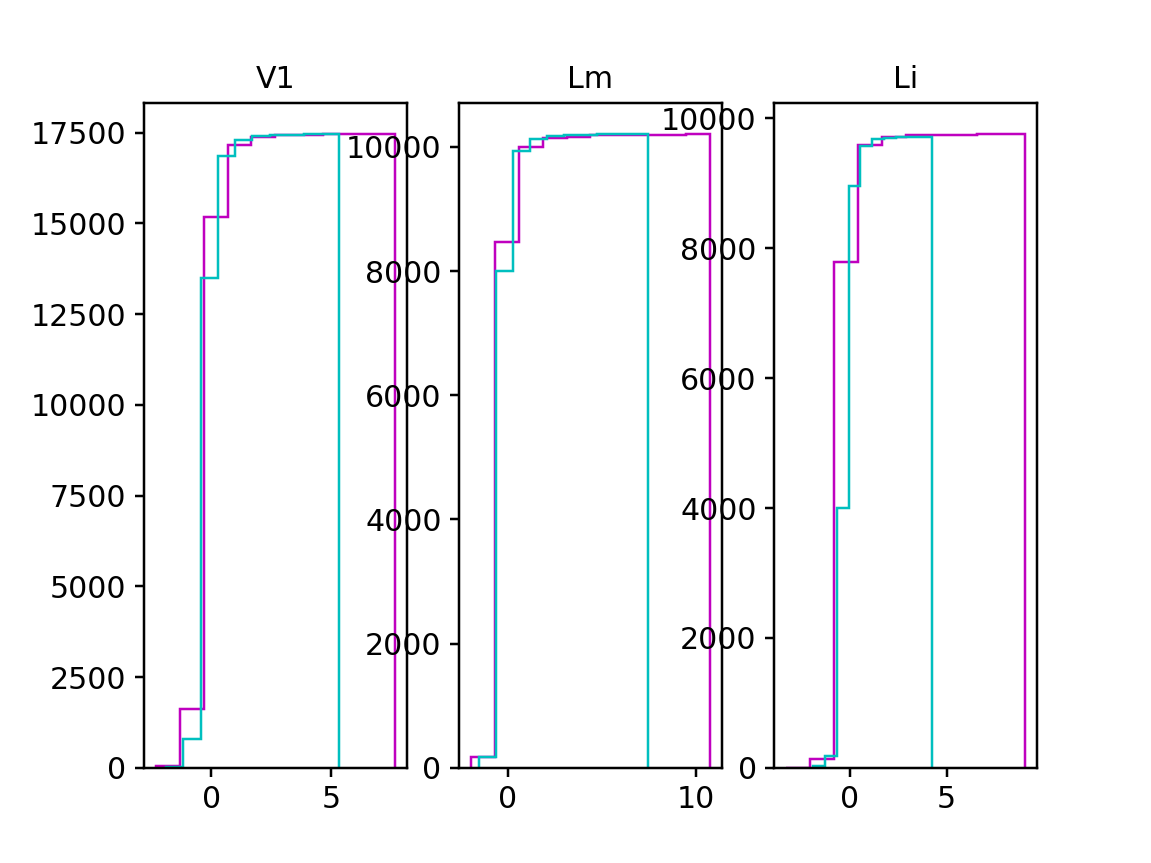

In [140]:
fig, axn = pl.subplots(1, 3)
for visual_area, g in neurald.groupby(['visual_area']):
    ai = visual_areas.index(visual_area)
    ax=axn[ai]
    hi_vals = g[g['arousal']==1].groupby(['datakey', 'cell', 'config']).mean()['response']
    lo_vals = g[g['arousal']==-1].groupby(['datakey', 'cell', 'config']).mean()['response']
    #sns.distplot(hi_vals, ax=ax, label='high', color='m')
    #sns.distplot(lo_vals, ax=ax, label='high', color='c')
    ax.hist(hi_vals, label='hi', color='m', cumulative=True, histtype='step')
    ax.hist(lo_vals, label='lo', color='c', cumulative=True, histtype='step')
    ax.set_title(visual_area)

In [147]:
meandf = neurald.groupby(['visual_area', 'datakey', 'cell', 'config', 'arousal']).mean().reset_index()
meandf.head()

,visual_area,datakey,cell,config,arousal,response,trial
0,Li,20190622_JC085_fov1,11,config001,-1,0.323599,717.666667
1,Li,20190622_JC085_fov1,11,config001,0,0.176138,688.727273
2,Li,20190622_JC085_fov1,11,config001,1,0.342229,843.600000
3,Li,20190622_JC085_fov1,11,config002,-1,0.254465,617.700000
4,Li,20190622_JC085_fov1,11,config002,0,-0.057658,821.875000


In [168]:
maxdf = meandf.groupby(['visual_area', 'datakey', 'cell', 'arousal']).mean().reset_index()

In [169]:
maxdf.head()

,visual_area,datakey,cell,arousal,response,trial
0,Li,20190622_JC085_fov1,11,-1,-0.133064,723.045688
1,Li,20190622_JC085_fov1,11,0,-0.112242,647.449425
2,Li,20190622_JC085_fov1,11,1,-0.078608,881.113057
3,Li,20190622_JC085_fov1,12,-1,-0.049156,852.694357
4,Li,20190622_JC085_fov1,12,0,-0.084848,702.599997


<IPython.core.display.Javascript object>


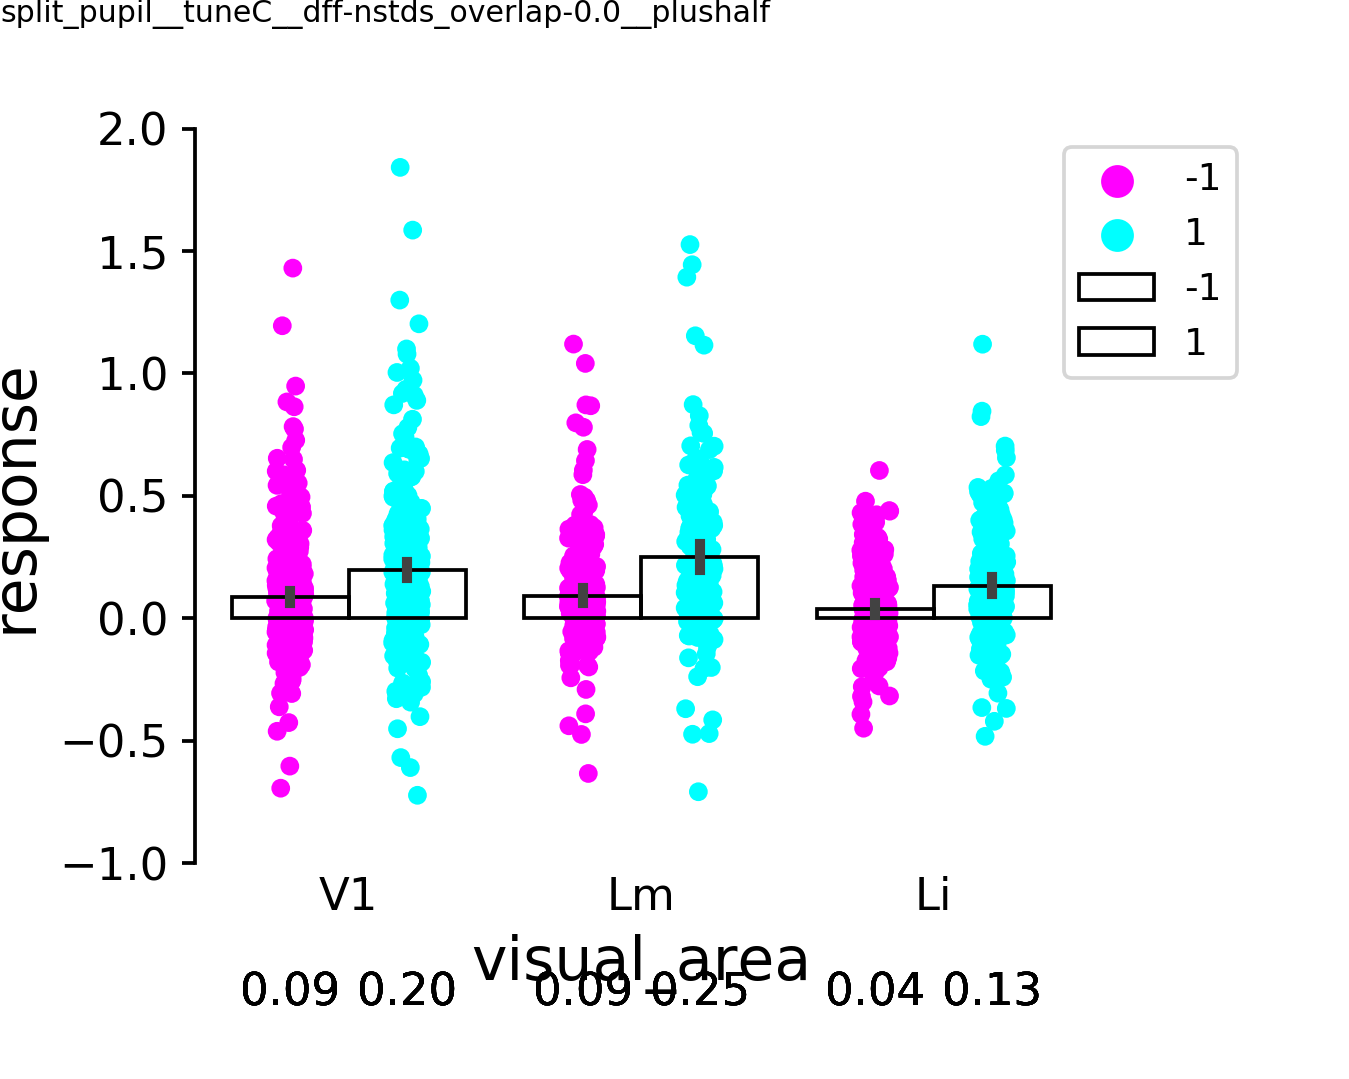

('/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/split_pupil', 'mean_dff_all_cells__pupil-lo-hi__split_pupil__tuneC__dff-nstds_overlap-0.0__plushalf')


In [187]:
palette=['magenta', 'cyan']

fig, ax = pl.subplots(dpi=dpi, figsize=(5,4))

plotdf = maxdf[maxdf['arousal'].isin([1, -1])].copy()
sns.stripplot(x='visual_area', y='response', hue='arousal', data=plotdf, ax=ax, 
              palette=palette, dodge=True, zorder=-1, order=visual_areas)
sns.barplot(x='visual_area', y='response', hue='arousal', data=plotdf, ax=ax, zorder=-1, 
            edgecolor=('k', 'k', 'k'), facecolor='none', order=visual_areas)
plotdf.apply(aggr.annotateBars, ax=ax,fontsize=12, fontcolor='k', xytext=(0, -100))

ax.set_ylim([-1, 2])
sns.despine(trim=True, offset=2, bottom=True)
ax.tick_params(which='both', axis='x', size=0)
ax.legend(bbox_to_anchor=(1.2, 1))
pl.subplots_adjust(left=0.15, bottom=0.2, right=0.8)

putils.label_figure(fig, data_id)

figname = 'mean_dff_all_cells__pupil-lo-hi__%s' % data_id
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)

In [185]:
dst_dir
#.violinplot(x='visual_area', y='response', hue='arousal', data=plotdf, ax=ax)


'/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/split_pupil'

In [64]:
res.groupby(['arousal']).mean()

,C,fit_time,heldout_MI,heldout_aMI,heldout_log2MI,heldout_test_score,n_cells,n_trials,score_time,test_score,train_score
arousal,,,,,,,,,,,
all,1.68544,0.087181,0.007377,-0.001454,0.010643,0.499667,87,300,0.001039,0.547263,0.748294
high,0.04915,0.000669,0.038996,0.006119,0.056259,0.480833,87,58,0.000231,0.585556,0.832829
low,0.01918,0.000669,0.016481,-0.007244,0.023778,0.533846,87,64,0.000242,0.573491,0.721539


In [293]:
reload(aggr)

<module 'pipeline.python.classifications.aggregate_data_stats' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/aggregate_data_stats.py'>

# Load aggregate

In [451]:
C_value=None
match_distns=True
overlap_thr=0#0.
responsive_test='nstds' #None
responsive_thr=10

trial_epoch='plushalf' #'stimulus'
analysis_type='split_pupil'

# -------------------------------------------------------------------------------------
#C_str = 'tuneC' if C_value is None else 'C-%.2f' % float(C_value)
data_id = dc.create_aggr_results_id(prefix=analysis_type, C_value=C_value,
                                    response_type=response_type, responsive_test=responsive_test,
                                    overlap_thr=overlap_thr, trial_epoch=trial_epoch)

df = dc.do_decode_within_fov(analysis_type=analysis_type, experiment=experiment, verbose=False,
                             responsive_test=responsive_test, responsive_thr=responsive_thr,
                            response_type=response_type, traceid=traceid, C_value=C_value, 
                             trial_epoch=trial_epoch, overlap_thr=overlap_thr, match_distns=match_distns)

df['animalid'] = [d.split('_')[1] for d in df['datakey']]
df['session'] = [d.split('_')[0] for d in df['datakey']]
df['fovnum'] = [int(d.split('_')[2][3:]) for d in df['datakey']]


AGGREGATE: split_pupil___dff-nstds_overlap0.0__plushalf__tuneC
AGGREGATE: split_pupil___dff-nstds_overlap0.0__plushalf__tuneC
Segmentation: missing 9 dsets
Segmentation: missing 9 dsets
No results for 11 dsets:
SAVING.....
-- results: /n/coxfs01/julianarhee/aggregate-visual-areas/decoding/split_pupil/split_pupil___dff-nstds_overlap0.0__plushalf__tuneC.pkl
-- params: /n/coxfs01/julianarhee/aggregate-visual-areas/decoding/split_pupil/split_pupil___dff-nstds_overlap0.0__plushalf__tuneC_params.json
DONE!


In [452]:
df[~(df['condition'].isin(['data', 'shuffled']))][['visual_area', 'datakey']].drop_duplicates()

,visual_area,datakey
0,Lm,20190430_JC078_fov1
0,Lm,20190506_JC080_fov1
0,Lm,20190508_JC083_fov1
0,Lm,20190512_JC083_fov1
0,Lm,20190525_JC084_fov1
0,Lm,20190603_JC080_fov1
0,Lm,20190618_JC097_fov1


In [453]:
min_ncells=5

bad_training = df[df['test_score']<0.25]['datakey'].unique()
few_cells = df[df['n_cells']<min_ncells]['datakey'].unique()

excluded = np.union1d(bad_training, few_cells)

print("Excluding %i datakeys for bad training: %s" % (len(bad_training), str(bad_training)))
print("Excluding %i datakeys for too few cells: %s" % (len(few_cells), str(few_cells)))


Excluding 0 datakeys for bad training: []
Excluding 0 datakeys for too few cells: []


In [454]:
meandf = df.groupby(['visual_area', 'datakey', 'condition', 'arousal']).mean().reset_index()
meandf[['visual_area', 'datakey']].drop_duplicates()

,visual_area,datakey
0,Li,20190602_JC091_fov1
6,Li,20190606_JC091_fov1
12,Li,20190607_JC091_fov1
18,Li,20190609_JC099_fov1
24,Li,20190612_JC099_fov1
30,Li,20190614_JC091_fov1
36,Li,20191018_JC113_fov1
42,Lm,20190504_JC078_fov1
48,Lm,20190513_JC078_fov1
54,Lm,20190517_JC083_fov1


<IPython.core.display.Javascript object>


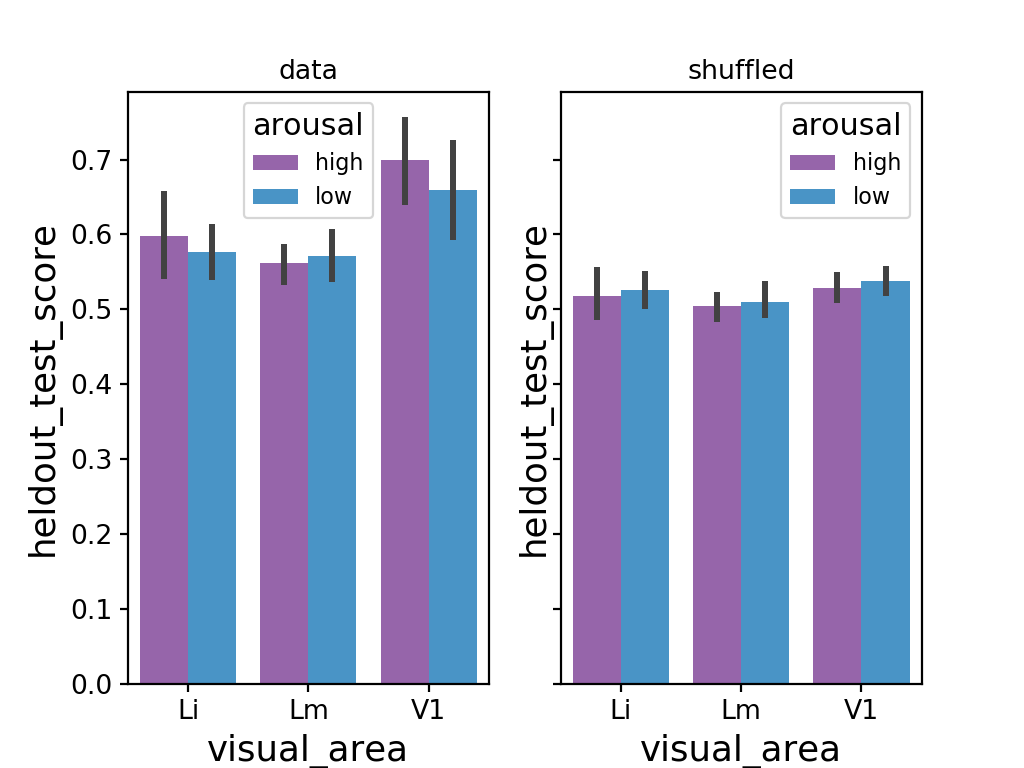

In [455]:
metric='heldout_test_score'
plotdf = meandf[meandf['arousal'].isin(['low', 'high'])].copy()

fig, axn = pl.subplots(1,2, sharey=True)

ax=axn[0]; ax.set_title('data')
df_ = plotdf[plotdf['condition']=='data'].copy()
sns.barplot(x='visual_area', y=metric, data=df_,
              hue='arousal', dodge=True, ax=ax) #, pl.figure()

ax=axn[1]; ax.set_title('shuffled')
df_ = plotdf[plotdf['condition']=='shuffled'].copy()
sns.barplot(x='visual_area', y=metric, data=df_,
              hue='arousal', dodge=True, ax=ax) #, pl.figure()


## Check N trials per cond?

In [456]:
ntrials_score = df.groupby(['datakey', 'arousal'])['heldout_test_score', 'n_trials'].mean().reset_index()
ntrials_score.head()

,datakey,arousal,heldout_test_score,n_trials
0,20190430_JC078_fov1,all,0.609310,290
1,20190430_JC078_fov1,high,0.605000,98
2,20190430_JC078_fov1,low,0.560500,98
3,20190504_JC078_fov1,all,0.537750,300
4,20190504_JC078_fov1,high,0.547727,107


<IPython.core.display.Javascript object>


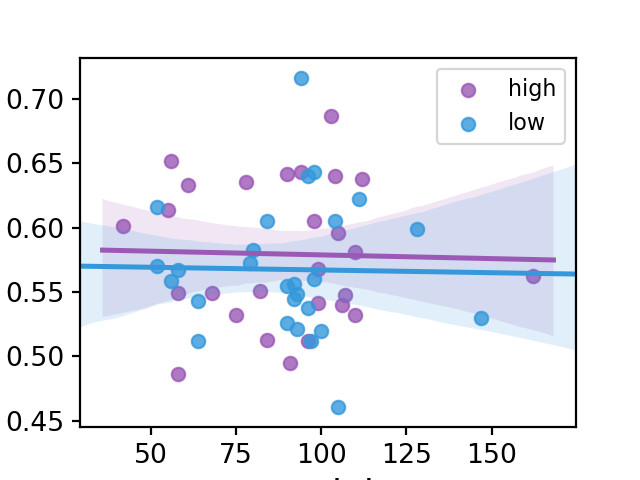

In [457]:
fig, ax = pl.subplots(figsize=(4,3))

x1=ntrials_score[ntrials_score['arousal']=='high']
sns.regplot(x1['n_trials'], x1['heldout_test_score'], label='high')

x2=ntrials_score[ntrials_score['arousal']=='low']
sns.regplot(x2['n_trials'], x2['heldout_test_score'], label='low')

pl.legend()

## Check significance

In [458]:
s_=[]
for (visual_area, datakey), d_ in df[df['arousal']=='all'].groupby(['visual_area', 'datakey']):
                            
    mean_score = d_[d_['condition']=='data'][metric].mean()
    percentile = np.mean(mean_score < d_[d_['condition']=='shuffled'][metric])
    
    s = pd.Series({'visual_area': visual_area, 'datakey': datakey, 
                   'mean_score': mean_score, 'percentile': percentile})
    s_.append(s)
    
scores = pd.concat(s_, axis=1).T

In [459]:
visual_area='V1'
scores[scores['visual_area']==visual_area]

,datakey,mean_score,percentile,visual_area
18,20190507_JC083_fov1,0.864,0,V1
19,20190510_JC083_fov1,0.794571,0,V1
20,20190511_JC083_fov1,0.7325,0,V1
21,20190512_JC083_fov1,0.553387,0.07,V1
22,20190522_JC084_fov1,0.755,0,V1
23,20190613_JC097_fov1,0.722,0,V1
24,20190616_JC097_fov1,0.7735,0,V1
25,20190617_JC097_fov1,0.706724,0,V1
26,20190622_JC085_fov1,0.6625,0.01,V1
27,20191006_JC110_fov1,0.740152,0,V1


In [460]:
df[['visual_area', 'datakey']].drop_duplicates().groupby(['visual_area'])['datakey'].count()


visual_area
Li     7
Lm    11
V1    10
Name: datakey, dtype: int64

In [461]:
area_dkeys = edata[edata['visual_area']=='V1']['datakey'].unique()
[k for k in area_dkeys if k not in df[df['visual_area']=='V1']['datakey'].unique()]
## NO cells.

['20190420_JC076_fov1',
 '20190501_JC076_fov1',
 '20190504_JC078_fov1',
 '20190508_JC083_fov1',
 '20190509_JC078_fov1',
 '20190517_JC083_fov1']

<IPython.core.display.Javascript object>


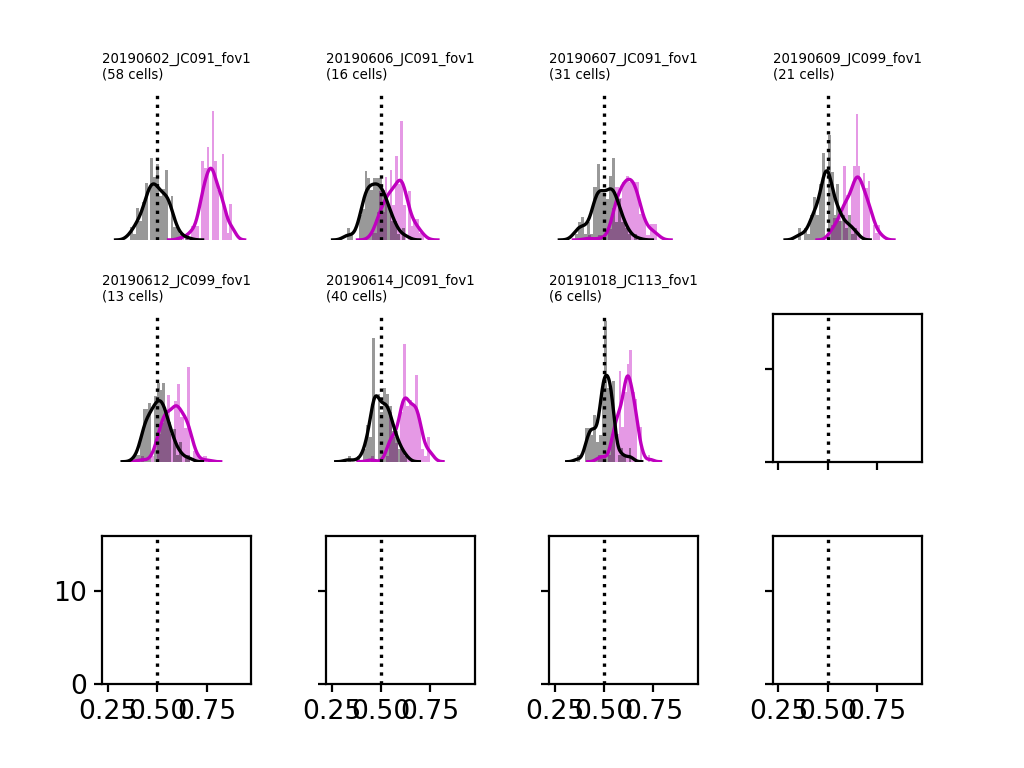

In [462]:
visual_area='Li'

plotdf = df[(df['arousal']=='all') & (df['visual_area']==visual_area)]

## plot
fig, axn = pl.subplots(3, 4, sharex=True, sharey=True)

for ax, (datakey, d_) in zip(axn.flat, plotdf.groupby(['datakey'])):
    #datakey = '20190507_JC083_fov1'

    d_ = df[(df['arousal']=='all') & (df['datakey']==datakey) & (df['visual_area']==visual_area)]
    n_cells = d_['n_cells'].unique()[0]
    
    metric = 'heldout_test_score'
    #print(d_.groupby(['condition']).mean()[metric])
    
    sns.distplot(d_[d_['condition']=='data'][metric], ax=ax, bins=20, color='m')
    sns.distplot(d_[d_['condition']=='shuffled'][metric], ax=ax, bins=20, color='k')
    #ax.axvline(x=0.5, linestyle=':', color='k')

    ax.set_title('%s\n(%i cells)' % (datakey, n_cells), fontsize=6, loc='left')
    ax.axis('off')
    
pl.subplots_adjust(left=0.1, right=0.9, wspace=0.5, hspace=0.5)

for ax in axn.flat:
    ax.axvline(x=0.5, linestyle=':', color='k')

## Threshold performance

In [463]:
p_thr=0.01
pass_scores = scores[scores['percentile']<p_thr]
pass_scores[pass_scores['visual_area']==visual_area]


,datakey,mean_score,percentile,visual_area
0,20190602_JC091_fov1,0.775862,0,Li
5,20190614_JC091_fov1,0.6375,0,Li


<IPython.core.display.Javascript object>


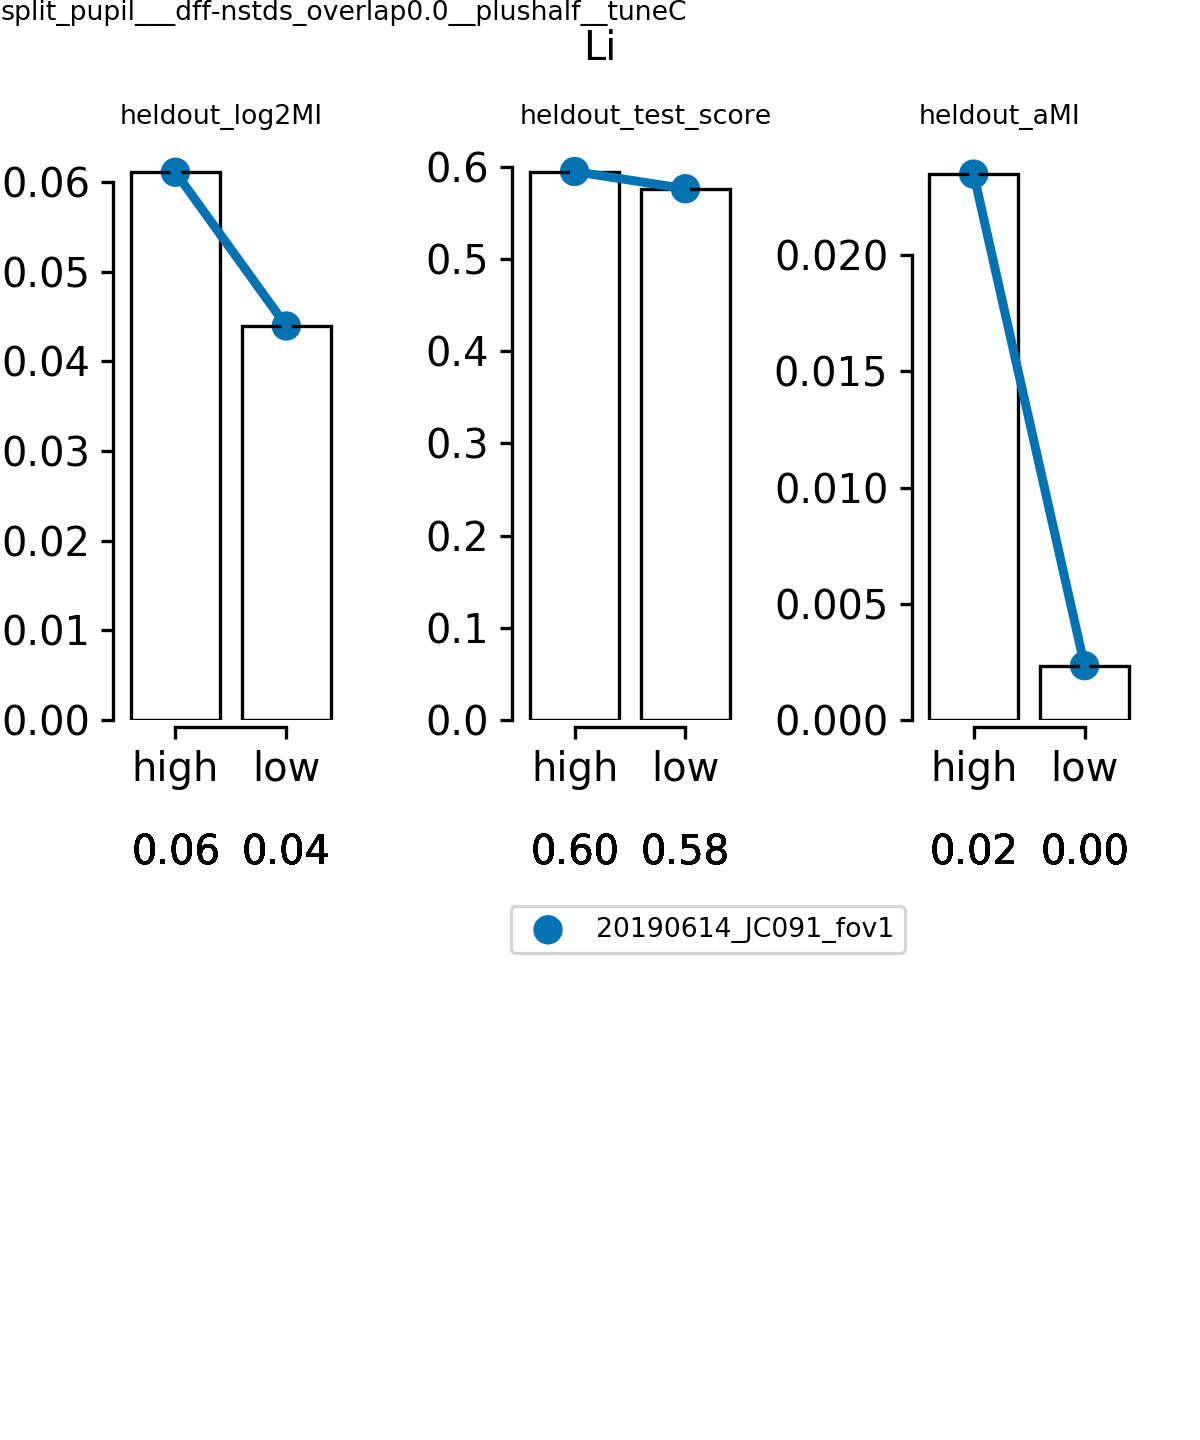

STATS - Li
heldout_log2MI--------------------
Paired t-test, t=nan (p=nan)
heldout_test_score--------------------
Paired t-test, t=nan (p=nan)
heldout_aMI--------------------
Paired t-test, t=nan (p=nan)
test_metrics_Li_color-datakeys__split_pupil___dff-nstds_overlap0.0__plushalf__tuneC


In [464]:
exclude_for_face ={'V1': ['20190510_JC083_fov1', '20190622_JC085_fov1', '20190617_JC097_fov1'],
                         #'20190507_JC083_fov1', '20190511_JC083_fov1'],
                  'Lm': ['20190506_JC080_fov1', '20190512_JC083_fov1'], 
                   'Li': ['20190502_JC076_fov1', '20191105_JC117_fov1', 
                          '20190602_JC091_fov1', '20190606_JC091_fov1', '20190607_JC091_fov1'] }

#
visual_area='Li'

pass_dkeys = pass_scores[(pass_scores['visual_area']==visual_area)]['datakey'].unique()
exclude = list(meandf[~meandf['datakey'].isin(pass_dkeys)]['datakey'].unique())
exclude.extend(exclude_for_face[visual_area])

vdf = meandf[(meandf['visual_area']==visual_area) 
         & (~meandf['datakey'].isin(exclude))
         & (meandf['condition']=='data')]

xdf = vdf[vdf['arousal'].isin(['low', 'high'])] #vdf[(~vdf['datakey'].isin(skip)) & (vdf['arousal'].isin(['low','high']))]
metrics = ['heldout_log2MI', 'heldout_test_score', 'heldout_aMI']
fig, axn = pl.subplots(1, 3, figsize=(5,6), dpi=dpi)
for ai, (ax, metric) in enumerate(zip(axn.flat, metrics)):
    # Plot each fov
    sns.pointplot(x='arousal', y=metric, hue='datakey', data=xdf, ax=ax, 
                  palette='colorblind', s=10, alpha=0.5)
    sns.barplot(x='arousal', y=metric, data=xdf, ax=ax, 
                edgecolor=('k', 'k', 'k'), facecolor=(1,1,1,0))
    xdf.apply(aggr.annotateBars, ax=ax,fontsize=12, fontcolor='k', xytext=(0, -40))
    if ai<2:
        ax.legend_.remove()
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title(metric, loc='left', fontsize=8)
    sns.despine(ax=ax, trim=True, offset=2)
ax.legend(bbox_to_anchor=(0, -0.3), fontsize=8)
pl.subplots_adjust(right=0.95, wspace=0.8, hspace=0.2, top=0.9, bottom=0.5, left=0.1)
fig.suptitle(visual_area)

print("STATS - %s" % visual_area)
metric = 'heldout_test_score'
for metric in metrics:
    print('%s--------------------' % metric)
    a = xdf[(xdf['arousal']=='low')][metric]
    b = xdf[(xdf['arousal']=='high')][metric]
    tstat, pval = spstats.ttest_rel(a, b)
    print("Paired t-test, t=%.2f (p=%.2f)" % (tstat, pval))

putils.label_figure(fig, data_id)

figname = 'test_metrics_%s_color-datakeys__%s' % (visual_area, data_id)
#pl.savefig(os.path.join(dst_dir, 'figures', '%s.svg' % figname))
print(figname)

In [57]:
dst_dir

'/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/split_pupil'

In [56]:
os.listdir(dst_dir)


['dff_nstds_overlap-0.2_iter-10',
 'split_pupil__C-1.00_dff-nstds.pkl',
 'split_pupil__C-1.00_dff-nstds_params.json',
 'split_pupil__tuneC_dff-nstds.pkl',
 'split_pupil__tuneC__dff-nstds_overlap-0.0.pkl',
 'split_pupil__tuneC__dff-nstds_overlap-0.0_params.json',
 'split_pupil__tuneC_dff-nstds_params.json',
 'figures',
 'paired_low-v-high_heldout_test_score__tuneC.svg',
 'paired_low-v-high_heldout_log2MI__tuneC.svg',
 'paired_low-v-high_heldout_aMI__tuneC.svg',
 'paired_low-v-high_n_trials__tuneC.svg']

# plotting

In [239]:
v1_exclude = ['20190510_JC083_fov1', '20190511_JC083_fov1', '20190507_JC083_fov1', '20190617_JC097_fov1', '20190622_JC085_fov1']
lm_exclude=['20190506_JC080_fov1', '20190512_JC083_fov1', '20190513_JC078_fov1', '20190603_JC080_fov1']
li_exclude=['20190502_JC076_fov', '20190602_JC091_fov1', '20190606_JC091_fov1', '20190607_JC091_fov1']


exclude = [v1_exclude, lm_exclude, li_exclude, excluded]
bad_dsets = [l for sublist in exclude for l in sublist ]
len(bad_dsets)

13

<IPython.core.display.Javascript object>


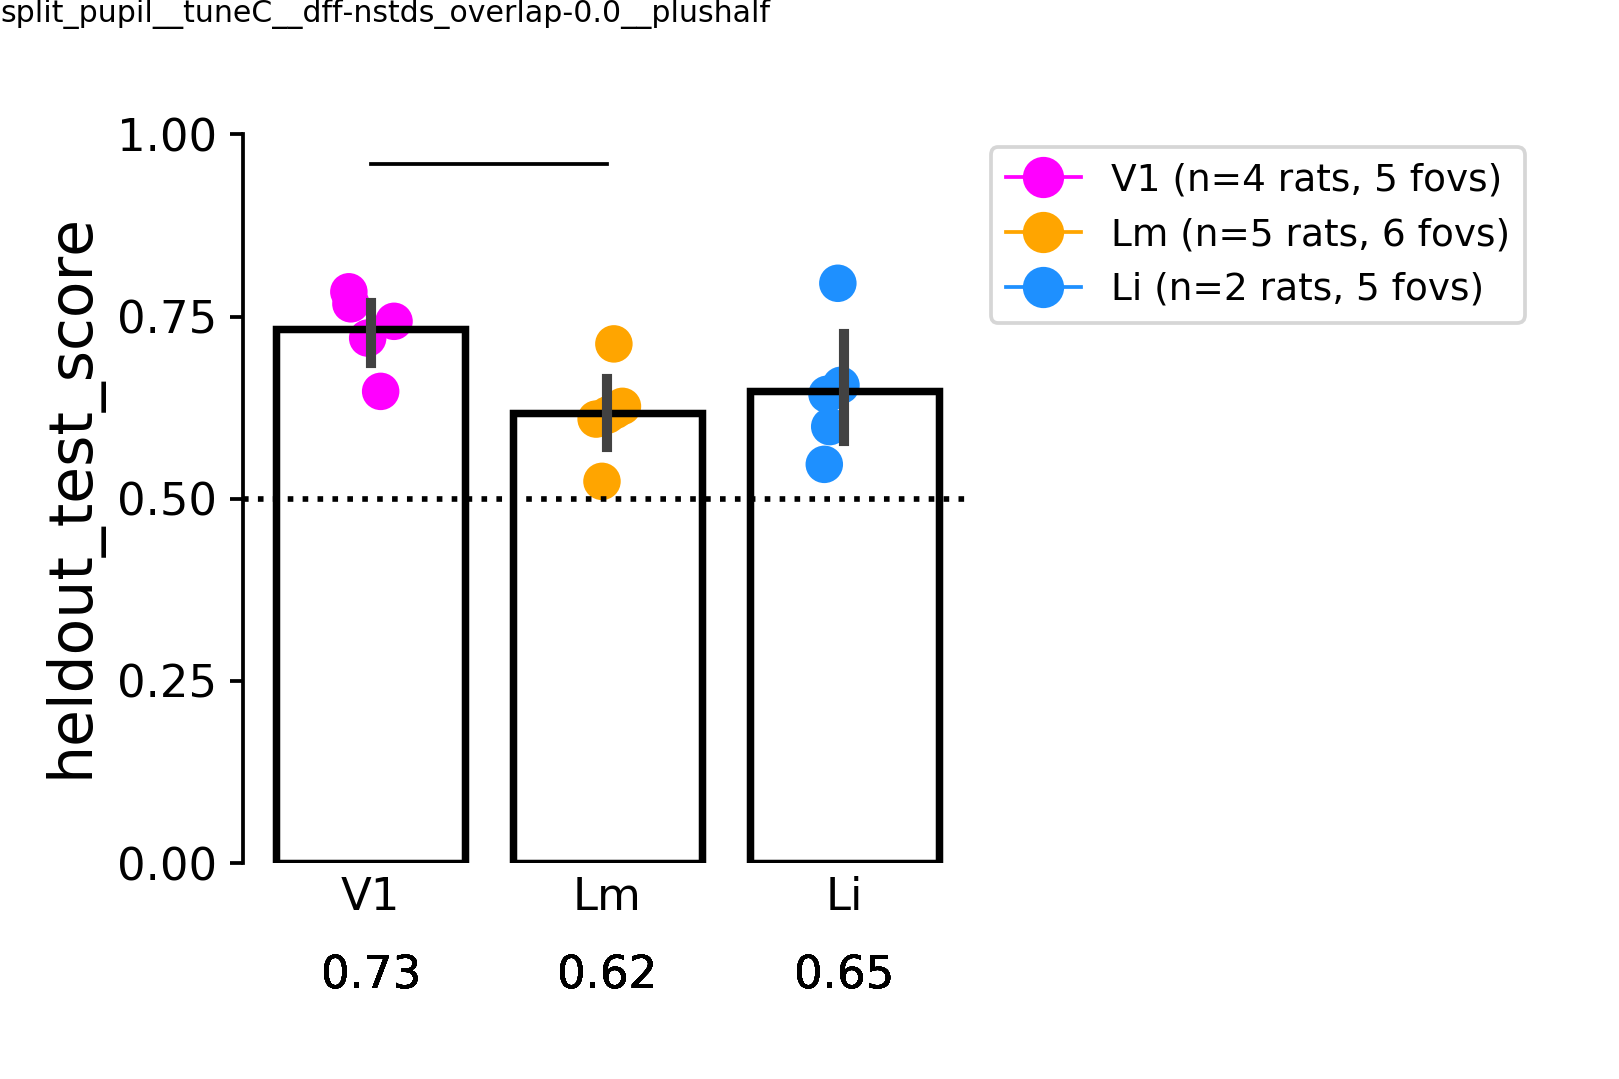

********* [heldout_test_score] Mann-Whitney U test(mc=fdr_bh) **********
[('V1', 'Lm')] p=0.021 (fdr_bh), reject H0=True
[('V1', 'Li')] p=0.158 (fdr_bh), reject H0=False
[('Lm', 'Li')] p=0.324 (fdr_bh), reject H0=False
****************************


In [47]:
metric = 'heldout_test_score'
#metric='heldout_log2MI'
multi_comp_test='fdr_bh'

f, ax = pl.subplots(dpi=dpi, figsize=(6,4))
f.patch.set_alpha(1)

plotdf = df[~df['datakey'].isin(exclude)].copy()


if 'pupil' in analysis_type:
    xdf = plotdf[plotdf['arousal']=='all']
else:
    xdf = plotdf.copy()

sns.barplot(x='visual_area', y=metric, data=xdf, ax=ax, order=visual_areas,
             edgecolor=('k', 'k', 'k'), facecolor='none', lw=2)

sns.stripplot(x='visual_area', y=metric, data=xdf, ax=ax,
             palette=area_colors, order=visual_areas, zorder=1, s=10)

xdf.apply(aggr.annotateBars, ax=ax,fontsize=12, fontcolor='k', xytext=(0, -30))

ax.tick_params(which='both', axis='x', size=0)
ax.set_xlabel('')

statsresults, ax = aggr.plot_mannwhitney(xdf, metric=metric, multi_comp_test=multi_comp_test, ax=ax)

leg = aggr.get_counts_for_legend(xdf, area_colors=area_colors, marker='o')
ax.legend(handles=leg, bbox_to_anchor=(1., 1))

if metric=='heldout_test_score':
    ax.set_yticks(np.linspace(0, 1, 5))
    sns.despine(ax=ax, trim=True)
    ax.axhline(y=0.5, ls=':', c='k')
sns.despine(bottom=True)
 
putils.label_figure(f, data_id)
pl.subplots_adjust(left=0.15, bottom=0.2, right=0.6)


# figname = 'overall_%s__%s' % (metric, data_id)
# pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
# print(dst_dir, figname)

<IPython.core.display.Javascript object>


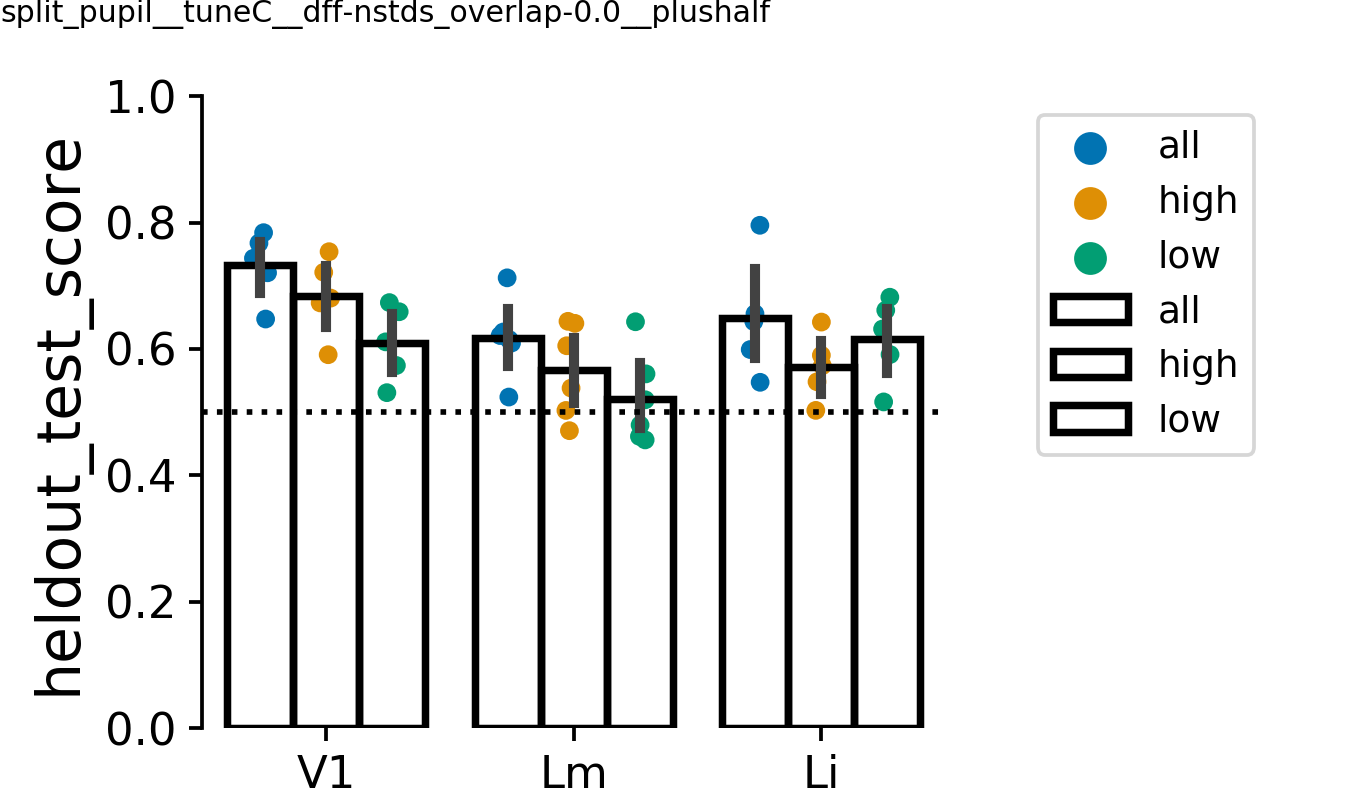

('/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/split_pupil', 'split_low-v-high_heldout_test_score__split_pupil__tuneC__dff-nstds_overlap-0.0__plushalf')


In [48]:
if 'pupil' in analysis_type:
    metric='heldout_test_score'
    f, ax = pl.subplots(dpi=dpi, figsize=(5,3))
    f.patch.set_alpha(1)

    sns.barplot(x='visual_area', y=metric, data=plotdf, ax=ax, hue='arousal',
                order=visual_areas,
                 edgecolor=('k', 'k', 'k'), facecolor='none', lw=2)

    sns.stripplot(x='visual_area', y=metric, data=plotdf, ax=ax, hue='arousal',
                 palette='colorblind', order=visual_areas, zorder=1, s=5, dodge=True)

    sns.despine(bottom=True, ax=ax)
    ax.set_ylim([0, 1])
    ax.axhline(y=0.5, ls=':', c='k')
    ax.legend(bbox_to_anchor=(1.1, 1))

    putils.label_figure(f, data_id)
    pl.subplots_adjust(right=0.7, bottom=0.1, left=0.15)

    figname = 'split_low-v-high_%s__%s' % (metric, data_id)
    #pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
    print(dst_dir, figname)

In [32]:
dst_dir

'/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/by_fov'

In [201]:
reload(aggr)

<module 'pipeline.python.classifications.aggregate_data_stats' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/aggregate_data_stats.pyc'>

<IPython.core.display.Javascript object>


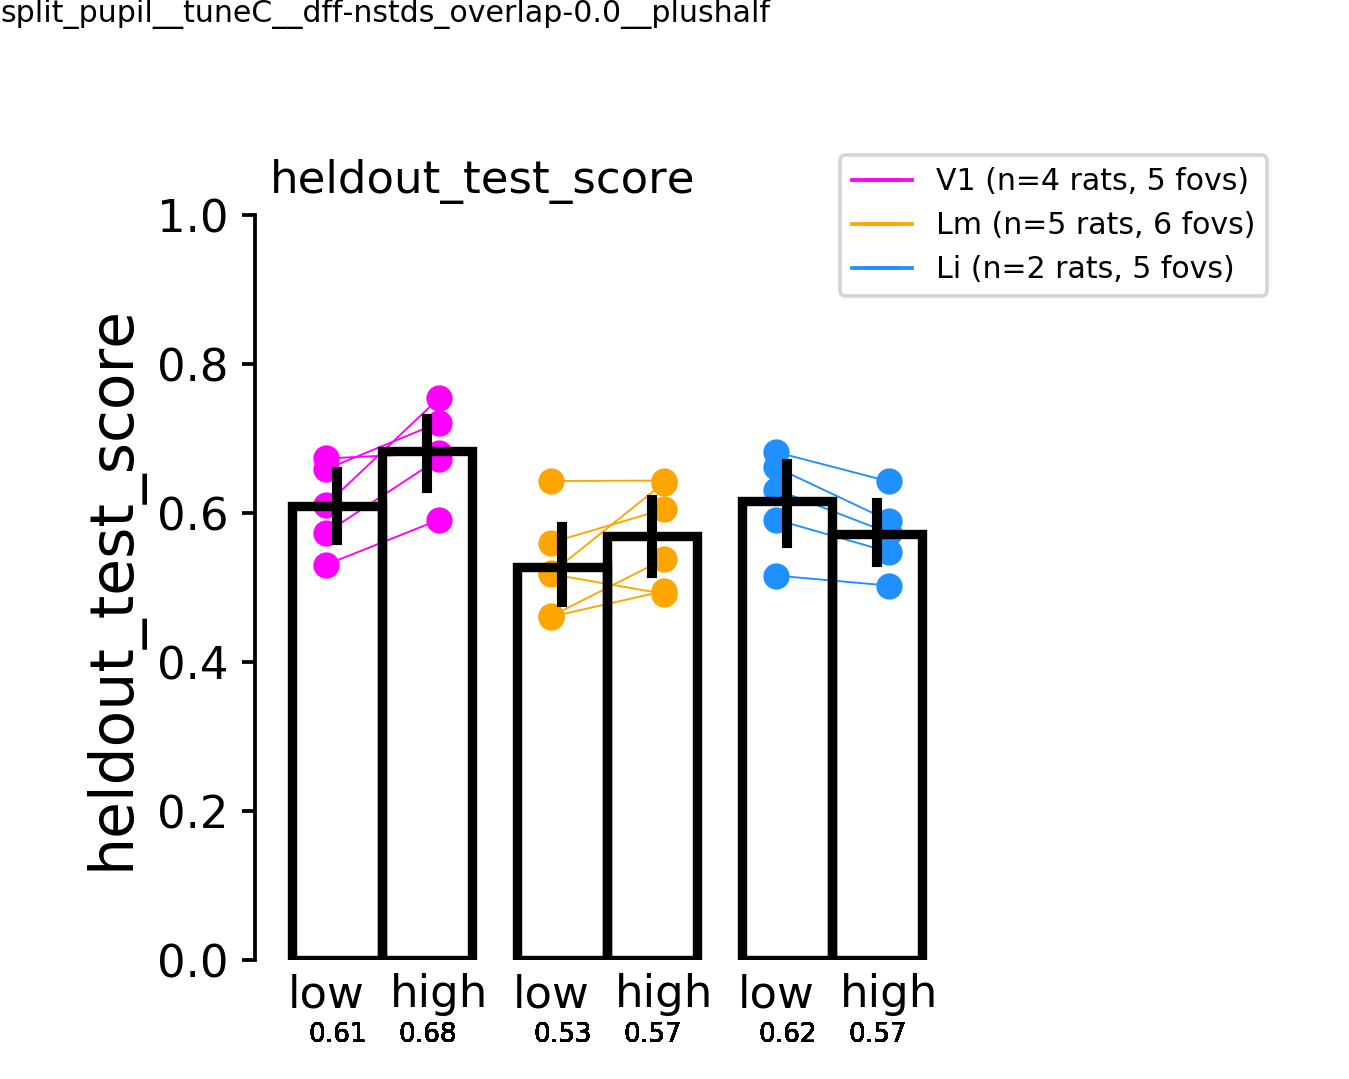

V1: (t-stat:-3.30, p=0.03)
Lm: (t-stat:-1.94, p=0.11)
Li: (t-stat:4.63, p=0.01)
('/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/split_pupil', 'paired_low-v-high_heldout_test_score__tuneC')


<IPython.core.display.Javascript object>


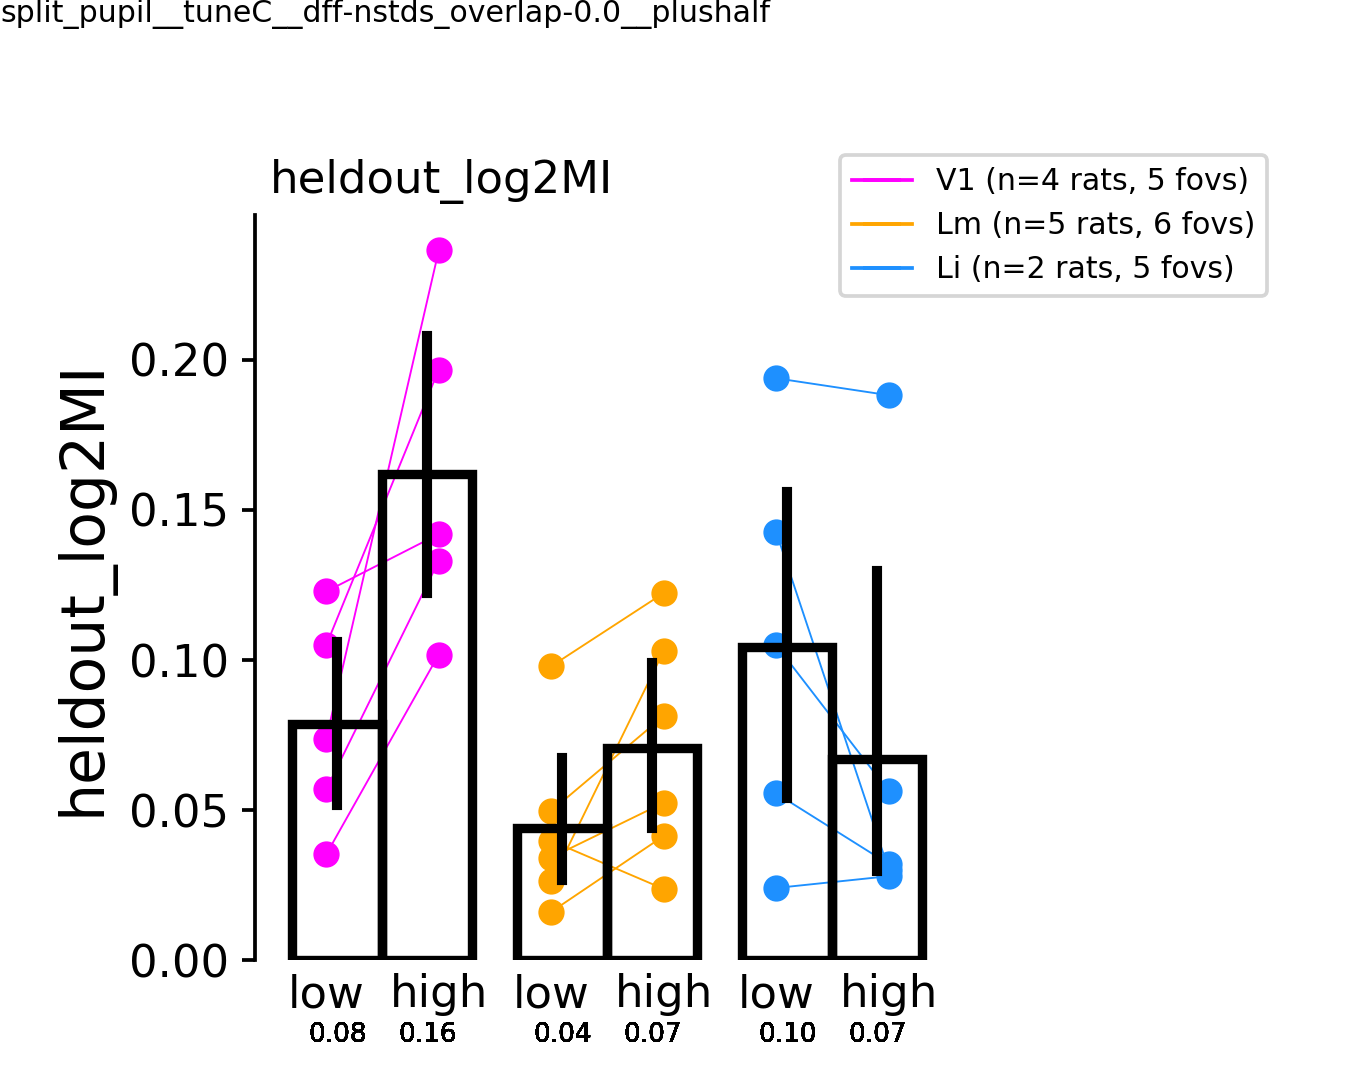

V1: (t-stat:-3.58, p=0.02)
Lm: (t-stat:-2.20, p=0.08)
Li: (t-stat:1.79, p=0.15)
('/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/split_pupil', 'paired_low-v-high_heldout_log2MI__tuneC')


<IPython.core.display.Javascript object>


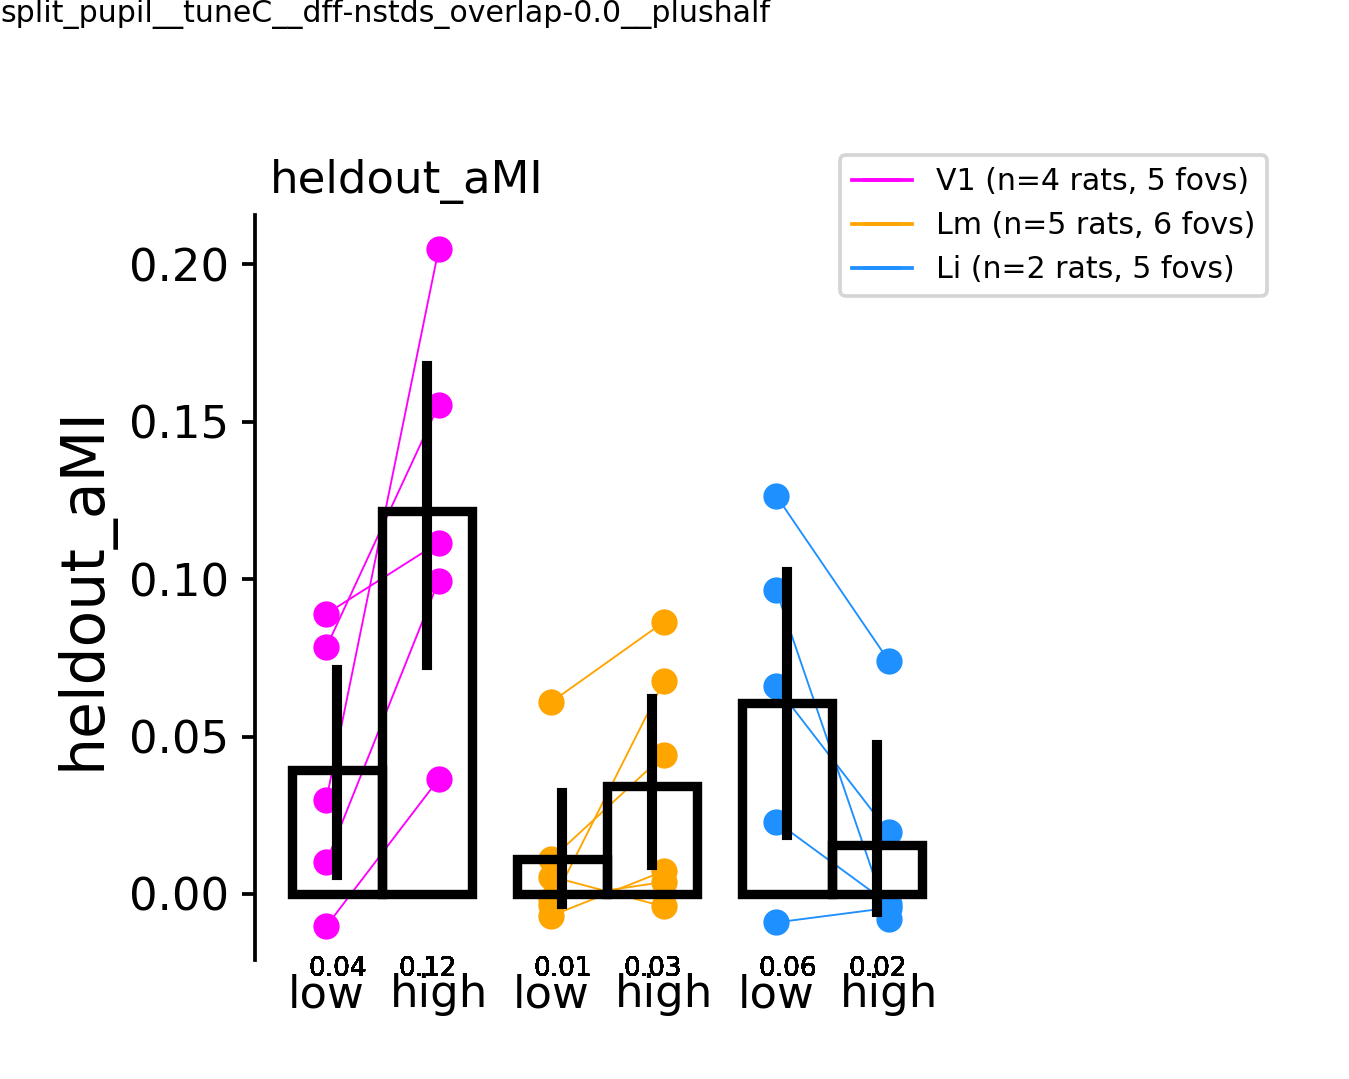

V1: (t-stat:-3.16, p=0.03)
Lm: (t-stat:-2.05, p=0.10)
Li: (t-stat:2.51, p=0.07)
('/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/split_pupil', 'paired_low-v-high_heldout_aMI__tuneC')


<IPython.core.display.Javascript object>


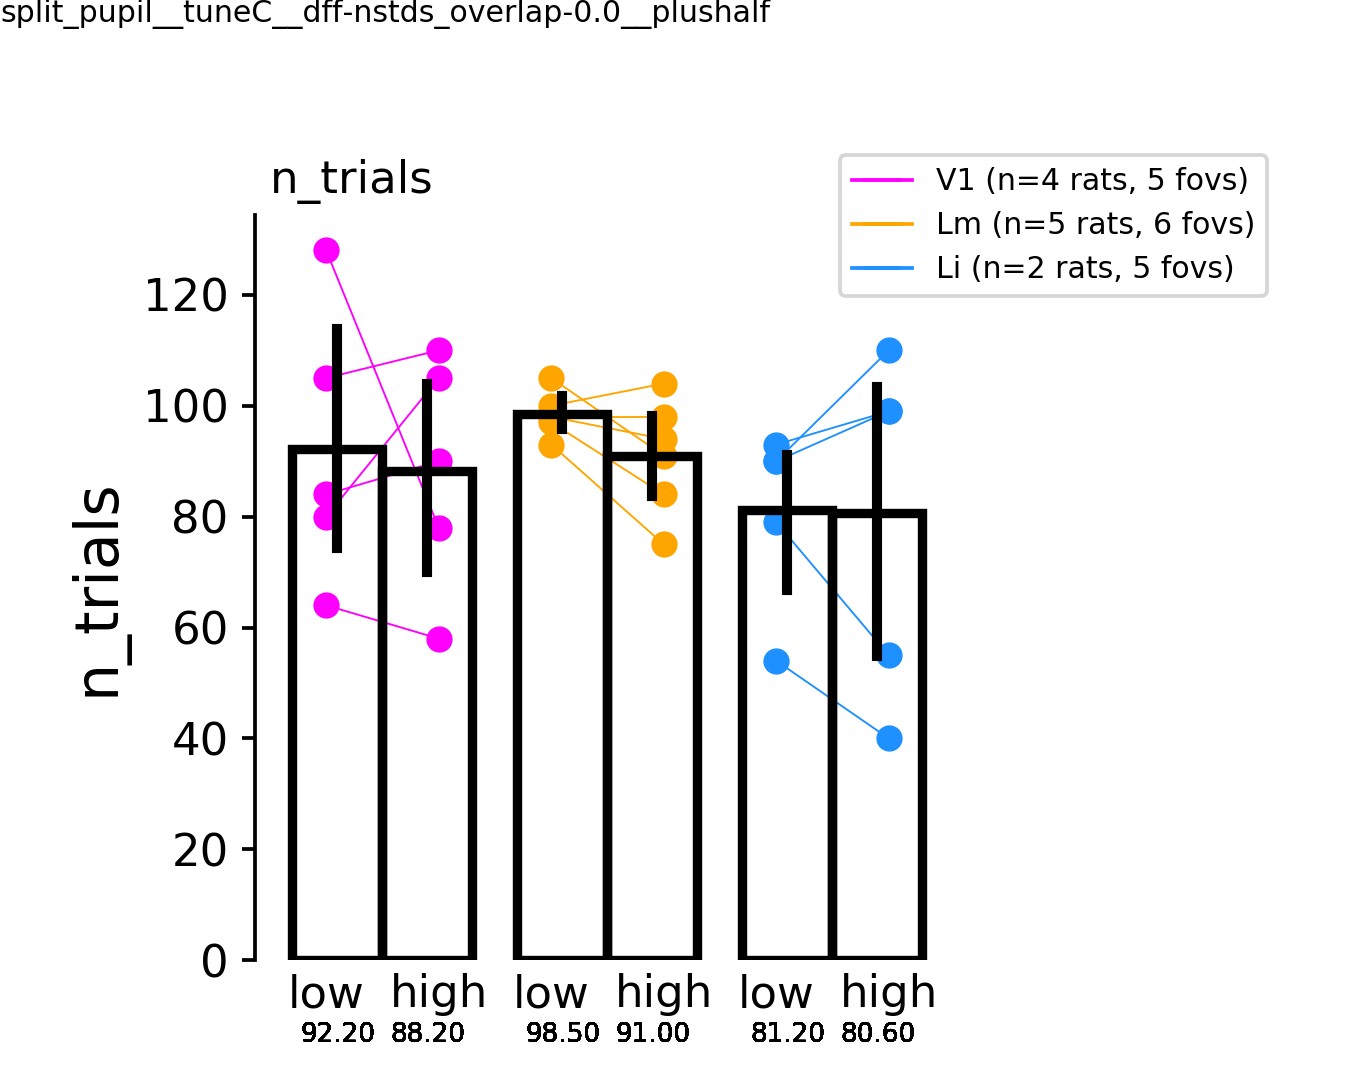

V1: (t-stat:0.32, p=0.77)
Lm: (t-stat:2.10, p=0.09)
Li: (t-stat:0.07, p=0.94)
('/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/split_pupil', 'paired_low-v-high_n_trials__tuneC')


In [196]:
metric = 'heldout_test_score'
#metric = 'abs_coef'
plotdf = df[~df['datakey'].isin(exclude)].copy()

currdf = plotdf[(plotdf['arousal'].isin(['low', 'high'])) & (~plotdf['datakey'].isin(exclude))]


for metric in ['heldout_test_score', 'heldout_log2MI','heldout_aMI', 'n_trials']:
    fig = aggr.plot_pairwise_by_axis(currdf, curr_metric=metric, c1='low', c2='high', compare_var='arousal',
                               area_colors=area_colors, fontsize=7, fontcolor='k', fmt='%.2f', xytext=(0, -20))
    pl.subplots_adjust(left=0.2, right=0.7, top=0.8)
    fig.axes[0].set_title(metric, loc='left')
    
    if metric=='heldout_test_score':
        fig.axes[0].set_ylim([0, 1])
    putils.label_figure(fig, data_id)
    
    figname = 'paired_low-v-high_%s__%s' % (metric, C_str)
    pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
    print(dst_dir, figname)

<IPython.core.display.Javascript object>


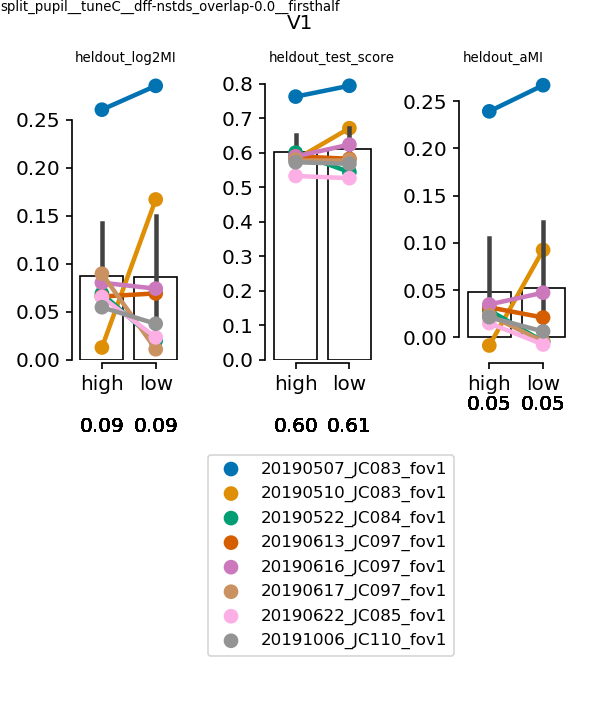

STATS - V1
heldout_log2MI--------------------
Paired t-test, t=-0.05 (p=0.96)
heldout_test_score--------------------
Paired t-test, t=0.68 (p=0.52)
heldout_aMI--------------------
Paired t-test, t=0.26 (p=0.81)
test_metrics_V1_color-datakeys__split_pupil__tuneC__dff-nstds_overlap-0.0__firsthalf


In [241]:
exclude =[] #copy.copy(v1_exclude)
#exclude=[]
visual_area='V1'

vdf = df[(df['visual_area']==visual_area) & (~df['datakey'].isin(exclude))]

xdf = vdf[vdf['arousal'].isin(['low', 'high'])] #vdf[(~vdf['datakey'].isin(skip)) & (vdf['arousal'].isin(['low','high']))]
metrics = ['heldout_log2MI', 'heldout_test_score', 'heldout_aMI']

fig, axn = pl.subplots(1, 3, figsize=(5,6), dpi=dpi)
for ai, (ax, metric) in enumerate(zip(axn.flat, metrics)):

    # Plot each fov
    sns.pointplot(x='arousal', y=metric, hue='datakey', data=xdf, ax=ax, 
                  palette='colorblind', s=10, alpha=0.5)

    sns.barplot(x='arousal', y=metric, data=xdf, ax=ax, 
                edgecolor=('k', 'k', 'k'), facecolor=(1,1,1,0))

    xdf.apply(aggr.annotateBars, ax=ax,fontsize=12, fontcolor='k', xytext=(0, -40))
    if ai<2:
        ax.legend_.remove()
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title(metric, loc='left', fontsize=8)
    sns.despine(ax=ax, trim=True, offset=2)
ax.legend(bbox_to_anchor=(0, -0.3))
pl.subplots_adjust(right=0.95, wspace=0.8, hspace=0.2, top=0.9, bottom=0.5)
fig.suptitle(visual_area)

#
print("STATS - %s" % visual_area)
metric = 'heldout_test_score'
for metric in metrics:
    print('%s--------------------' % metric)
    a = xdf[(xdf['arousal']=='low')][metric]
    b = xdf[(xdf['arousal']=='high')][metric]
    tstat, pval = spstats.ttest_rel(a, b)
    print("Paired t-test, t=%.2f (p=%.2f)" % (tstat, pval))

putils.label_figure(fig, data_id)


figname = 'test_metrics_%s_color-datakeys__%s' % (visual_area, data_id)
#|pl.savefig(os.path.join(dst_dir, 'figures', '%s.svg' % figname))
print(figname)

<IPython.core.display.Javascript object>


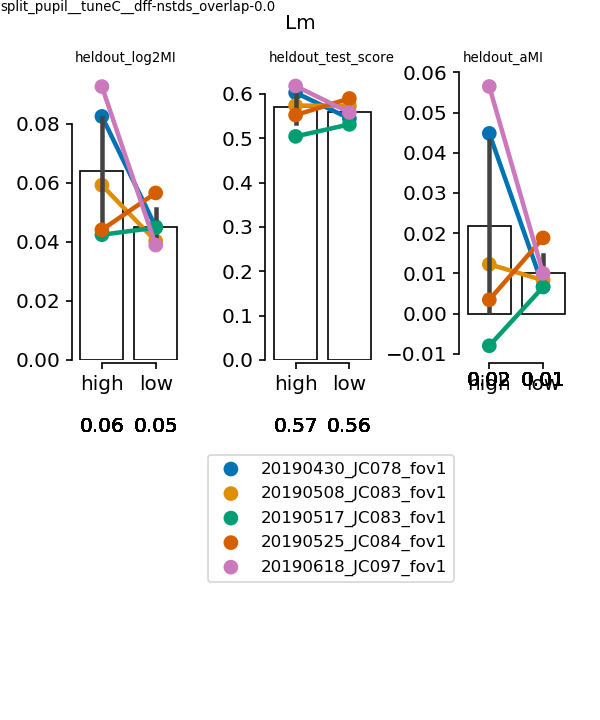

STATS - Lm
heldout_log2MI--------------------
Paired t-test, t=-1.56 (p=0.19)
heldout_test_score--------------------
Paired t-test, t=-0.52 (p=0.63)
heldout_aMI--------------------
Paired t-test, t=-0.90 (p=0.42)
test_metrics_Lm_color-datakeys__split_pupil__tuneC__dff-nstds_overlap-0.0


In [205]:
exclude=copy.copy(lm_exclude)
visual_area='Lm'
vdf = plotdf[(plotdf['visual_area']==visual_area) & (~plotdf['datakey'].isin(exclude))]

xdf = vdf[vdf['arousal'].isin(['low', 'high'])] #vdf[(~vdf['datakey'].isin(skip)) & (vdf['arousal'].isin(['low','high']))]
metrics = ['heldout_log2MI', 'heldout_test_score', 'heldout_aMI']

fig, axn = pl.subplots(1, 3, figsize=(5,6), dpi=dpi)
for ai, (ax, metric) in enumerate(zip(axn.flat, metrics)):

    # Plot each fov
    sns.pointplot(x='arousal', y=metric, hue='datakey', data=xdf, ax=ax, 
                  palette='colorblind', s=10, alpha=0.5)

    sns.barplot(x='arousal', y=metric, data=xdf, ax=ax, 
                edgecolor=('k', 'k', 'k'), facecolor=(1,1,1,0))

    xdf.apply(aggr.annotateBars, ax=ax,fontsize=12, fontcolor='k', xytext=(0, -40))
    if ai<2:
        ax.legend_.remove()
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title(metric, loc='left', fontsize=8)
    sns.despine(ax=ax, trim=True, offset=2)
ax.legend(bbox_to_anchor=(0, -0.3))
pl.subplots_adjust(right=0.95, wspace=0.8, hspace=0.2, top=0.9, bottom=0.5)
fig.suptitle(visual_area)

#
print("STATS - %s" % visual_area)
metric = 'heldout_test_score'
for metric in metrics:
    print('%s--------------------' % metric)
    a = xdf[(xdf['arousal']=='low')][metric]
    b = xdf[(xdf['arousal']=='high')][metric]
    tstat, pval = spstats.ttest_rel(a, b)
    print("Paired t-test, t=%.2f (p=%.2f)" % (tstat, pval))

putils.label_figure(fig, data_id)

figname = 'test_metrics_%s_color-datakeys__%s' % (visual_area, data_id)
pl.savefig(os.path.join(dst_dir, 'figures', '%s.svg' % figname))
print(figname)

<IPython.core.display.Javascript object>


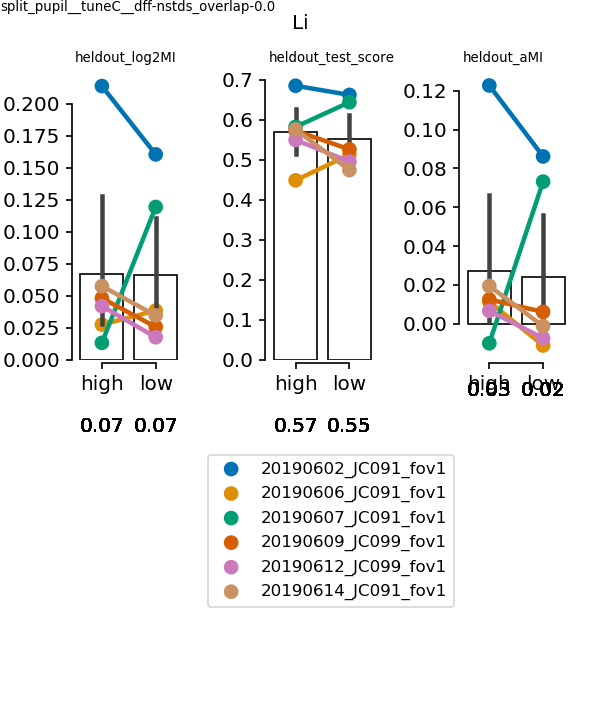

STATS - Li
heldout_log2MI--------------------
Paired t-test, t=-0.04 (p=0.97)
heldout_test_score--------------------
Paired t-test, t=-0.61 (p=0.57)
heldout_aMI--------------------
Paired t-test, t=-0.16 (p=0.88)
test_metrics_Li_color-datakeys__split_pupil__tuneC__dff-nstds_overlap-0.0


In [208]:
# exclude=['20190506_JC080_fov1', '20190512_JC083_fov1']
exclude = [] #copy.copy(li_exclude)
visual_area='Li'


#plotdf = df[~df['datakey'].isin(bad_dsets)].copy()

vdf = df[(df['visual_area']==visual_area) & (~df['datakey'].isin(exclude))]

xdf = vdf[vdf['arousal'].isin(['low', 'high'])] #vdf[(~vdf['datakey'].isin(skip)) & (vdf['arousal'].isin(['low','high']))]
metrics = ['heldout_log2MI', 'heldout_test_score', 'heldout_aMI']

fig, axn = pl.subplots(1, 3, figsize=(5,6), dpi=dpi)
for ai, (ax, metric) in enumerate(zip(axn.flat, metrics)):

    # Plot each fov
    sns.pointplot(x='arousal', y=metric, hue='datakey', data=xdf, ax=ax, 
                  palette='colorblind', s=10, alpha=0.5)

    sns.barplot(x='arousal', y=metric, data=xdf, ax=ax, 
                edgecolor=('k', 'k', 'k'), facecolor=(1,1,1,0))

    xdf.apply(aggr.annotateBars, ax=ax,fontsize=12, fontcolor='k', xytext=(0, -40))
    if ai<2:
        ax.legend_.remove()
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title(metric, loc='left', fontsize=8)
    sns.despine(ax=ax, trim=True, offset=2)
ax.legend(bbox_to_anchor=(0, -0.3))
pl.subplots_adjust(right=0.95, wspace=0.8, hspace=0.2, top=0.9, bottom=0.5)
fig.suptitle(visual_area)

#
print("STATS - %s" % visual_area)
metric = 'heldout_test_score'
for metric in metrics:
    print('%s--------------------' % metric)
    a = xdf[(xdf['arousal']=='low')][metric]
    b = xdf[(xdf['arousal']=='high')][metric]
    tstat, pval = spstats.ttest_rel(a, b)
    print("Paired t-test, t=%.2f (p=%.2f)" % (tstat, pval))

putils.label_figure(fig, data_id)

figname = 'test_metrics_%s_color-datakeys__%s' % (visual_area, data_id)
pl.savefig(os.path.join(dst_dir, 'figures', '%s.svg' % figname))
print(figname)

In [104]:
from pipeline.python.eyetracker import dlc_utils as dlcutils

In [109]:
reload(dlcutils)

<module 'pipeline.python.eyetracker.dlc_utils' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/eyetracker/dlc_utils.py'>

In [112]:

pupil_feature='pupil_fraction'
pupil_epoch = 'stimulus'
pupildata = dlcutils.get_aggregate_pupildfs(experiment=experiment, feature_name=pupil_feature,
                               trial_epoch=pupil_epoch, alignment_type='trial', 
                               in_rate=pupil_framerate, out_rate=pupil_framerate, 
                               iti_pre=iti_pre, iti_post=iti_post, stim_dur=stim_dur, create_new=True)


~~~~~ Aggregating pupil traces. ~~~~~~
Aggregated pupil traces. Missing 2 datasets.
20190422_JC076_fov1
20191008_JC091_fov1
~~~~~~~~~~~~ Aggregating pupil dataframes. ~~~~~~~~~~~
---> Saved aggr dataframes: /n/coxfs01/julianarhee/aggregate-visual-areas/behavior-state/metrics_blobs_pupil_fraction_stimulus_snapshot-391800.pkl


<IPython.core.display.Javascript object>


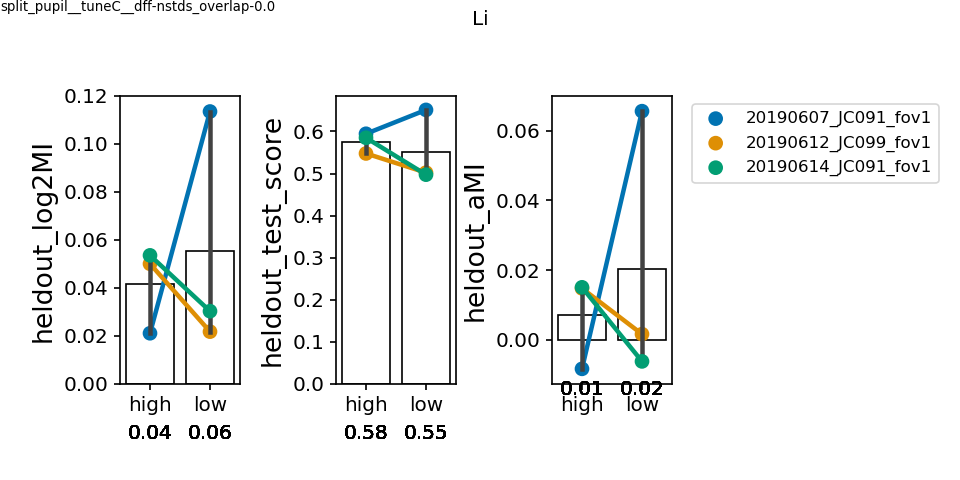

STATS - Li
heldout_log2MI--------------------
Paired t-test, t=0.35 (p=0.76)
heldout_test_score--------------------
Paired t-test, t=-0.59 (p=0.61)
heldout_aMI--------------------
Paired t-test, t=0.43 (p=0.71)


<IPython.core.display.Javascript object>


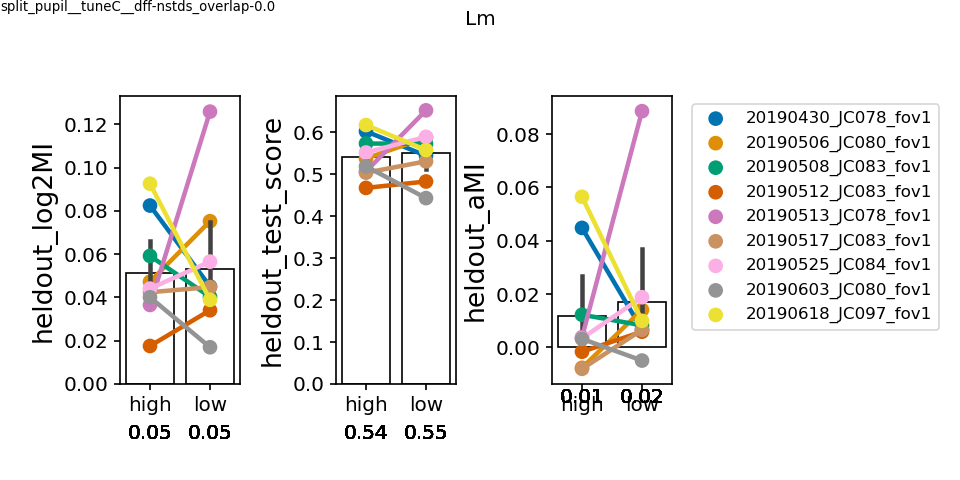

STATS - Lm
heldout_log2MI--------------------
Paired t-test, t=0.12 (p=0.91)
heldout_test_score--------------------
Paired t-test, t=0.39 (p=0.70)
heldout_aMI--------------------
Paired t-test, t=0.41 (p=0.69)


<IPython.core.display.Javascript object>


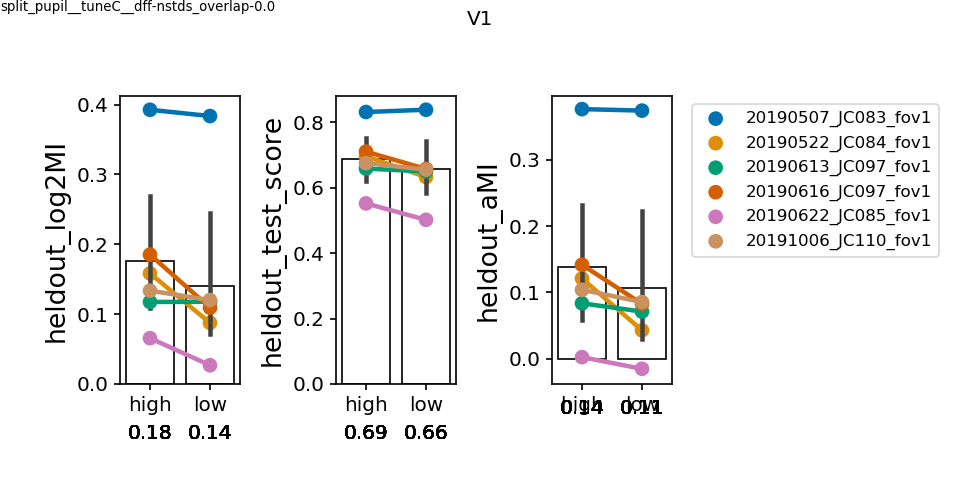

STATS - V1
heldout_log2MI--------------------
Paired t-test, t=-2.59 (p=0.05)
heldout_test_score--------------------
Paired t-test, t=-2.74 (p=0.04)
heldout_aMI--------------------
Paired t-test, t=-2.55 (p=0.05)


In [71]:

for visual_area, vdf in plotdf[~plotdf['datakey'].isin(exclude)].groupby(['visual_area']):

    xdf = vdf[vdf['arousal'].isin(['low', 'high'])] #vdf[(~vdf['datakey'].isin(skip)) & (vdf['arousal'].isin(['low','high']))]
    metrics = ['heldout_log2MI', 'heldout_test_score', 'heldout_aMI']

    fig, axn = pl.subplots(1, 3, figsize=(8,4), dpi=dpi)
    for ai, (ax, metric) in enumerate(zip(axn.flat, metrics)):

        # Plot each fov
        sns.pointplot(x='arousal', y=metric, hue='datakey', data=xdf, ax=ax, 
                      palette='colorblind', s=10, alpha=0.5)
        
        sns.barplot(x='arousal', y=metric, data=xdf, ax=ax, 
                    edgecolor=('k', 'k', 'k'), facecolor=(1,1,1,0))
        
        xdf.apply(aggr.annotateBars, ax=ax,fontsize=12, fontcolor='k', xytext=(0, -30))
        if ai<2:
            ax.legend_.remove()
        ax.set_xlabel('')

    ax.legend(bbox_to_anchor=(1.1, 1))
    pl.subplots_adjust(right=0.7, wspace=0.8, hspace=0.2, top=0.8, bottom=0.2)
    fig.suptitle(visual_area)
    
    #
    print("STATS - %s" % visual_area)
    metric = 'heldout_test_score'
    for metric in metrics:
        print('%s--------------------' % metric)
        a = xdf[(xdf['arousal']=='low')][metric]
        b = xdf[(xdf['arousal']=='high')][metric]
        tstat, pval = spstats.ttest_rel(a, b)
        print("Paired t-test, t=%.2f (p=%.2f)" % (tstat, pval))

    putils.label_figure(fig, data_id)
    #C_str = 'C-%.2f' % C_value if C_value is not None else 'tuneC'
    #figname = '%s_%s_morph%iv%i_%s_%i-iters' % (face_feature, visual_area, m0, m100, C_str, n_iterations)
    #pl.savefig(os.path.join(dst_dir, '%s.svg' %figname))
    #print(dst_dir, figname)

# By FOV

# Filter bad stuff

In [46]:
#### Calculate overlap with stimulus
stim_overlaps = rfutils.calculate_overlaps(RFDATA, experiment=experiment)

In [47]:
remove_too_few = True
min_ncells=0
overlap_thr=0.5

####
globalcells, cell_counts = decutils.get_pooled_cells(stim_overlaps, remove_too_few=remove_too_few,
                                                     overlap_thr=overlap_thr, min_ncells=min_ncells)


             cell
visual_area      
Li            181
Lm            299
V1            766
('V1', 766)
('Lm', 299)
('Li', 181)


In [49]:
pass_overlaps = stim_overlaps[stim_overlaps['perc_overlap']>=overlap_thr].copy()
counts_by_dset = aggr.get_counts_by_datakey(pass_overlaps)
counts_by_dset.groupby(['visual_area']).sum()

,n_cells,fovnum
visual_area,,
Li,181,10
Lm,299,13
V1,766,17


In [ ]:
dst_dir


<IPython.core.display.Javascript object>


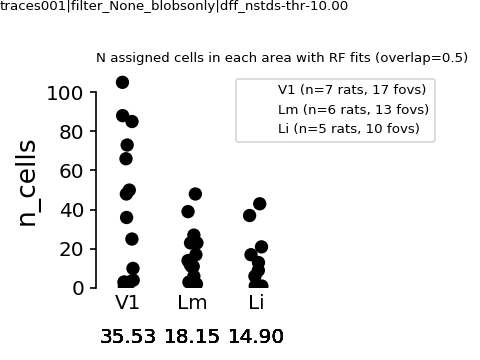

In [226]:
f, ax = pl.subplots(dpi=dpi, figsize=(4,3))
sns.stripplot(x='visual_area', y='n_cells', data=counts_by_dset, ax=ax,
             order=visual_areas, color='k', s=8, alpha=1)
sns.barplot(x='visual_area', y='n_cells', data=counts_by_dset, ax=ax,
             order=visual_areas, color='w', errcolor='w')
counts_by_dset.apply(aggr.annotateBars, ax=ax,fontsize=12, fontcolor='k', xytext=(0, -30))


ax.tick_params(which='both', axis='x', size=0)
ax.set_ylim([0, ax.get_ylim()[-1]])
sns.despine(bottom=True, trim=True, ax=ax)

ax.set_xlabel('')
pl.subplots_adjust(left=0.2, bottom=0.2, top=0.8)
ax.set_title("N assigned cells in each area with RF fits (overlap=%.1f)" % overlap_thr, loc='left', fontsize=8)
putils.label_figure(f, data_id)

leg = aggr.get_counts_for_legend(counts_by_dset, markersize=0, lw=0)
ax.legend(handles=leg, bbox_to_anchor=(1.8,1), fontsize=8)
pl.subplots_adjust(left=0.2, right=0.6, bottom=0.2)

figname = 'ncells_assigned_with_rfs__%s-%s__match-Li-distn' % (response_type, responsive_test)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))


# Decode

In [17]:

test_split=0.2
cv_nfolds=5
C_value=None

class_a=0
class_b=106


#### Test boot iter for 1 cell

In [23]:
curr_ncells = 1
gdf = globalcells[globalcells['visual_area']=='V1'].copy() # globalcells for current visual_area


In [24]:
visual_area = 'V1'

datakey = '20190613_JC097_fov1'
sdf = SDF[datakey]
gdf = globalcells[globalcells['visual_area']==visual_area].copy() # globalcells for current visual_area

rid = 2
rid in gdf['dset_roi']


True

In [25]:
curr_data = NEURALDATA[visual_area][datakey][[rid, 'config']].copy()
print(curr_data.shape)
assert len(curr_data['config'].value_counts().unique())==1, "(%s) ERR: uneven trial counts by config" % datakey


(1500, 2)


In [26]:
n_iterations=100

i_=[]; s_=[];
for inum in np.arange(0, n_iterations):
    it_df, sh_df = decutils.do_fit_within_fov(inum, curr_data=curr_data, sdf=sdf, return_shuffle=True,
                                        C_value=C_value, test_split=test_split, cv_nfolds=cv_nfolds, 
                                        class_a=class_a, class_b=class_b)
    i_.append(it_df)
    s_.append(sh_df)
    
iterdf = pd.concat(i_, axis=0)
shufdf = pd.concat(s_, axis=0)
iterdf.mean()

<IPython.core.display.Javascript object>


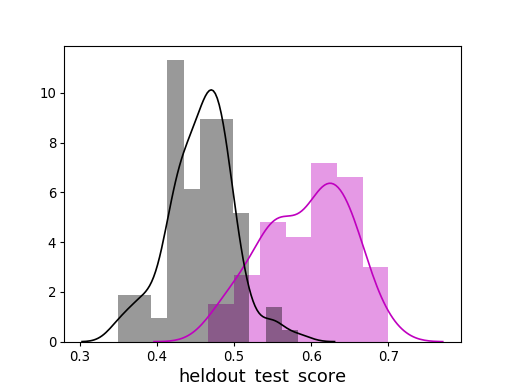

In [29]:
metric='heldout_test_score'
ci=0.95

f, ax = pl.subplots()
sns.distplot(iterdf[metric], color='m')
sns.distplot(shufdf[metric], color='k')

# ci_lo, ci_hi = putils.get_empirical_ci(iterdf[metric].values, ci=ci)
# ax.axvline(x=ci_lo, linestyle=':', c='k')
# ax.axvline(x=ci_hi, linestyle=':', c='k')

In [8]:
def load_cell_results_from_fov(animalid, session, fov, experiment, traceid='traces001',
                               C_value=None, response_type='dff', responsive_test='nstds',
                              rootdir='/n/coxfs01/2p-data'):
    '''
    From running batch, slurm/decode_by_ncells.py (Set analysis_type='single_cells'),
    load all the cells' results.
    '''
    roidf=None
    sub_dir = '%s-%s' % (response_type, responsive_test)
    #print(sub_dir)
    C_str = 'tuneC' if C_value is None else 'C-%.2f' % C_value
    cell_results = glob.glob(os.path.join(rootdir, animalid, session, fov, 
                            'combined_%s_static' % experiment, 'traces', '%s*' % traceid, 
                            'decoding', 'single_cells', sub_dir, '*%s*.pkl' % C_str))

    #print("... %i cell results" % len(cell_results))

    rlist=[]
    for c in cell_results:
        with open(c, 'rb') as f:
            r_ = pkl.load(f)
        means_ = r_.mean()
        non_num = [i for i in r_.columns if i not in means_.index]
        #metainfo = dict((k, r_[k].unique()[0]) for k in non_num)
        for k in non_num:
            means_[k] = r_[k].unique()[0]
        means_ = pd.to_numeric(r_.mean())

        rlist.append(means_)
        
    if len(rlist)>0:
        roidf = pd.concat(rlist, axis=1).T
    
    return roidf


In [ ]:
# INFO:  [7763640]: 20190507_JC083_fov1_V1_tuneC
# INFO:  [7763651]: 20190522_JC084_fov1_V1_tuneC   
        
# INFO:  [7763654]: 20190613_JC097_fov1_V1_tuneC 
# INFO:  [7763657]: 20190616_JC097_fov1_V1_tuneC 
# INFO:  [7763659]: 20190617_JC097_fov1_V1_tuneC
# INFO:  [7763661]: 20190622_JC085_fov1_V1_tuneC
# INFO:  [7763664]: 20191006_JC110_fov1_V1_tuneC

In [9]:
rootdir='/n/coxfs01/2p-data'
traceid='traces001'
experiment='blobs'
# -----------------------------------------------------
response_type='dff'
responsive_test='nstds'
# -----------------------------------------------------


In [ ]:
visual_area = 'Li'
animalid = 'JC091'
session = '20190614'
fovnum = 1
fov = 'FOV%i_zoom2p0x' % fovnum
datakey = '%s_%s_fov%i' % (session, animalid, fovnum)

# curr_ncells = globalcells[(globalcells['datakey']==datakey) & (globalcells['visual_area']==visual_area)].shape
roidf = load_cell_results_from_fov(animalid, session, fov, experiment, traceid=traceid,
                                   C_value=None, response_type=response_type, responsive_test=responsive_test,
                                   rootdir=rootdir)
curr_ncells = roidf.shape[0]
metainfo = {'datakey': datakey, 'visual_area': visual_area}
roidf = putils.add_meta_to_df(roidf, metainfo)


In [20]:
print(roidf.shape)
sub_dir = '%s-%s' % (response_type, responsive_test)
print(sub_dir)
C_str = 'tuneC' if C_value is None else 'C-%.2f' % C_value
cell_results = glob.glob(os.path.join(rootdir, animalid, session, fov, 
                        'combined_%s_static' % experiment, 'traces', '%s*' % traceid, 
                        'decoding', 'single_cells', sub_dir, '*%s*.pkl' % C_str))
print(len(cell_results))

(37, 14)
dff-nstds
37


<IPython.core.display.Javascript object>


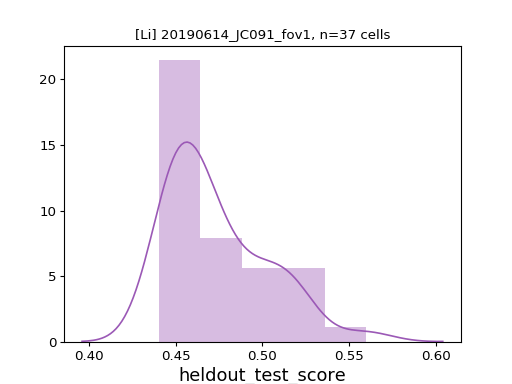

Text(0.5,1,u'[Li] 20190614_JC091_fov1, n=37 cells')

In [21]:
fig, ax = pl.subplots()
sns.distplot(roidf['heldout_test_score'], ax=ax)
ax.set_title("[%s] %s, n=%i cells" % (visual_area, datakey, curr_ncells))



In [10]:
r_list=[]
for (visual_area, animalid, session, fovnum, datakey), g in globalcells.groupby(['visual_area', 'animalid', 'session', 'fovnum', 'datakey']):
    roidf = load_cell_results_from_fov(animalid, session, 'FOV%i_zoom2p0x' % fovnum, experiment, traceid=traceid,rootdir=rootdir)
    if roidf is None:
        print("[%s] %s - No cells." % (visual_area, datakey))
        continue
    curr_ncells = roidf.shape[0]
    print("[%s] %s, n=%i cells" % (visual_area, datakey, curr_ncells))
    metainfo = {'datakey': datakey, 'visual_area': visual_area}
    roidf = putils.add_meta_to_df(roidf, metainfo)
    r_list.append(roidf)
singledf = pd.concat(r_list, axis=0)

NameError: name 'globalcells' is not defined

In [ ]:
INFO:  [7985264]: 20190430_JC078_fov1_Lm_tuneC
INFO:  [7985267]: 20190506_JC080_fov1_Lm_tuneC
INFO:  [7985271]: 20190513_JC078_fov1_Lm_tuneC
INFO:  [7985273]: 20190525_JC084_fov1_Lm_tuneC
INFO:  [7985276]: 20190618_JC097_fov1_Lm_tuneC
INFO:  [7985274]: 20190603_JC080_fov1_Lm_tuneC
        
INFO:  [7985265]: 20190504_JC078_fov1_Lm_tuneC
INFO:  [7985268]: 20190508_JC083_fov1_Lm_tuneC
INFO:  [7985269]: 20190509_JC078_fov1_Lm_tuneC
INFO:  [7985270]: 20190512_JC083_fov1_Lm_tuneC
INFO:  [7985272]: 20190517_JC083_fov1_Lm_tuneC
INFO:  [7985277]: 20190627_JC091_fov1_Lm_tune


In [47]:
min_ncells=60
curr_dkeys = [k for k, g in singledf.groupby(['datakey']) if len(g)<min_ncells]

<IPython.core.display.Javascript object>


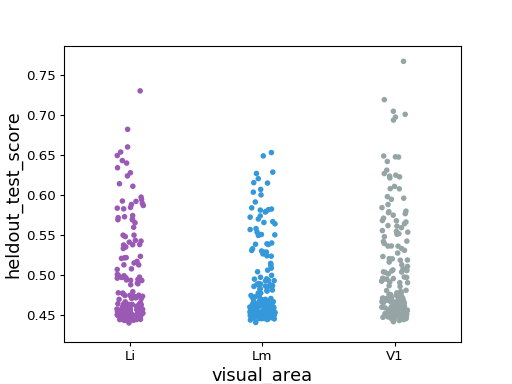

In [49]:
metric='heldout_test_score'

fig, ax = pl.subplots()
sns.stripplot(x='visual_area', y=metric, data=singledf[singledf['datakey'].isin(curr_dkeys)], ax=ax)

In [28]:
singledf.groupby(['visual_area']).mean()

,C,fit_time,heldout_MI,heldout_aMI,heldout_log2MI,heldout_test_score,n_cells,n_trials,score_time,test_score,train_score,cell
visual_area,,,,,,,,,,,,
Li,8.390145,0.001162,0.011191,0.008852,0.016145,0.498520,1.0,296.392405,0.000312,0.540805,0.545417,152.436709
Lm,7.421948,0.001123,0.008848,0.005680,0.012765,0.488769,1.0,296.011236,0.000319,0.533930,0.538750,116.831461
V1,7.736929,0.001147,0.012561,0.010258,0.018121,0.508667,1.0,303.130755,0.000292,0.546073,0.550571,107.425414


<IPython.core.display.Javascript object>


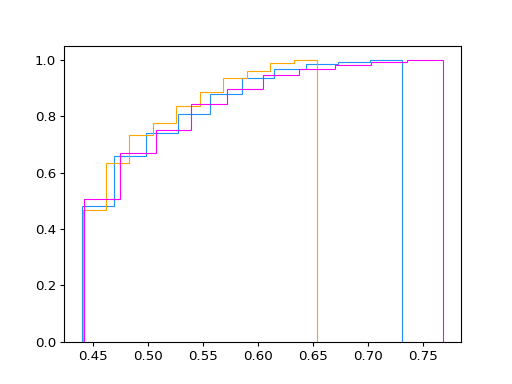

In [51]:
metric='heldout_test_score'
fig, ax = pl.subplots()
# for visual_area, vdf in singledf.groupby(['visual_area']):
#     sns.distplot(vdf[metric].values, color=area_colors[visual_area], ax=ax, kde=False, #bins=100,
#                 hist_kws={"histtype": "step", "linewidth": 3})

xdf = singledf[singledf['datakey'].isin(curr_dkeys)]
for visual_area, vdf in xdf.groupby(['visual_area']):
    n, bins, patches = ax.hist(vdf[metric].values, color=area_colors[visual_area],
                                density=True, histtype='step', cumulative=True)
    
    
